# Week HW 18

Last Audit: HW18

注意：
1. Model
- 變數改為 Constant
- 加入 try except
- train 之前清空變數
2. 最後檢查
- 變數名稱一致
- 變數 return 與 接用 順序是否一致
3. Testing
- model parameter 可能 load 不到
- 訓練結果（result）可能是空的
4. Analysis
- 抓數值或結果時，要小心 None 的出現


*** 開發時記得 commit





# Pips


In [3]:
%pip install gurobipy>=10
%pip install gurobipy_pandas
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

zsh:1: 10 not found
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 5.8 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.6 MB/s eta 0:00:00

[notice] A new release of 

# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
data_size = 10
train_size = 0.8
testing_size = 0.2

# data_size = 10 # 最小要是 2
# train_size = 1
# testing_size = 0

T = 10
service_level = 0.95  # 服務水準
M = 5000000

assigned_Fs = np.arange(0.1, 1.0, 0.1)
assigned_Ts = list(range(2, T))  # 2 到 T-1

np.random.seed(0)


# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 2000
MIPGAP = 0.3
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

## Visualization 

In [ ]:
def plot_strategies_profits_scatter(dfs):
    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if dfs[i] is None or dfs[j] is None:
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
def plot_relative_profit_deviation(baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    # 顯示圖表
    plt.show()

In [ ]:
def plot_relative_profit_comparison(
    train_baseline_profit, test_baseline_profit, test_max_profits, train_max_profits
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    # Show plot
    plt.show()

## Others

In [6]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [7]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [151]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        # "tau_values": tau_values,
        "Q0_vars": Q0_vars,
        "Q1_vars": Q1_vars,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Import Data


## Data1: Training data for LR


### Making full data


In [13]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(80, 90, data_size),
        "X2": np.random.randint(1, 4, data_size),
    }
)

full_df

,X1,X2
0,85.488135,3
1,87.151894,3
2,86.027634,1
3,85.448832,2
4,84.236548,2
5,86.458941,2
6,84.375872,2
7,88.917730,1
8,89.636628,2
9,83.834415,1


In [14]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [ ]:
training_df, testing_df = (
    full_df[: int(data_size * train_size)],
    full_df[int(data_size * train_size) :],
)
testing_df.reset_index(drop=True, inplace=True)
print(f"training_data size: {training_df.shape}")
print(f"testing_df size: {testing_df.shape}")

training_data size: (8, 2)
testing_df size: (2, 2)


In [16]:
# #### Only for testing
# training_df = testing_df = full_df

## Data2: demand_df


### mu of each time(t)


In [17]:
# 設定 b0, b1, b2
b0 = 0
b1 = 0.17
b2 = 0.01


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    # 設定隨機種子
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 + random_noises[t - 1]
        )

    return mu_matrix

In [18]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (10, 10)
mu_matrix[0]: 
[16.3270353  14.96314017 15.54172094 16.80387616 16.43054095 13.58570508
 15.51307137 14.41162575 14.4597641  14.97358146]


### sigma matrix


In [19]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [20]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((10, 10),
 array([[8.80673389, 7.63280743, 8.41098231, 5.59668261, 8.3114155 ,
         7.45890176, 8.71313616, 8.76975606, 8.10928163, 6.97539827],
        [8.7607317 , 7.64982621, 8.4827804 , 5.8472482 , 8.29097365,
         7.14150796, 8.80382389, 8.51568858, 7.92447856, 6.9669412 ],
        [8.71201034, 7.65849414, 8.41054211, 5.94348432, 8.26087969,
         7.30280203, 8.70845128, 8.55141572, 7.97543962, 7.04550925],
        [8.87710813, 7.61369941, 8.43140672, 5.34945565, 8.35155285,
         7.51546012, 8.74288769, 8.88825924, 8.17960988, 6.90783409],
        [8.24739213, 7.75239263, 8.18499218, 7.14106678, 8.02282519,
         7.33192276, 8.38162944, 7.94179168, 7.74007748, 7.44937769],
        [8.43372744, 7.72231954, 8.35686305, 6.79268128, 8.1193892 ,
         7.04973349, 8.62615711, 7.97825643, 7.68770024, 7.25606946],
        [8.22050766, 7.75785647, 8.1862009 , 7.21099022, 8.01080768,
         7.2938576 , 8.38228257, 7.87304707, 7.70610414, 7.46276885],
        [9.01989

### corr matrix


In [21]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [22]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (10, 10, 10)
cov_matrices: 
[[ 77.55856174  23.8122372   41.1687159   28.95258624 -28.38364784
  -10.60766973  -7.60227929 -21.31193132 -34.91479863  -1.28541398]
 [ 23.8122372   58.25974927  41.45171804  14.70575904 -33.87426524
   -6.75868972 -24.38104611   4.83493149   6.80603496  -2.61557776]
 [ 41.1687159   41.45171804  70.74462339  12.22633156 -29.95463901
  -14.83850942 -40.42041426   0.7791173  -28.25449377  -7.55133433]
 [ 28.95258624  14.70575904  12.22633156  31.32285626 -20.1748666
   -3.29625922   8.10627949 -30.97151057   4.04558705   9.53244286]
 [-28.38364784 -33.87426524 -29.95463901 -20.1748666   69.07962755
   23.02452398  21.74802287  21.4308264  -10.36061986  -6.29315035]
 [-10.60766973  -6.75868972 -14.83850942  -3.29625922  23.02452398
   55.63521541  42.78265797  34.04783457 -20.67046384   7.67001908]
 [ -7.60227929 -24.38104611 -40.42041426   8.10627949  21.74802287
   42.78265797  75.91874175   2.97559158  -0.69045897  29.53002922]
 [-21.31

In [23]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [24]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,20.362071,-6.977505,1.876173,13.829487,37.999804,15.730623,27.761683,12.674387,6.486290,18.042602
1,26.929636,14.523356,14.822453,16.152803,19.770065,19.908182,20.363275,23.823347,3.777147,15.516722
2,40.456521,27.668716,39.352082,24.551533,6.717207,4.817971,4.145474,12.307168,9.069881,26.554605
3,11.865725,26.270771,15.672362,11.333333,12.788370,15.638919,15.334353,30.165226,20.723089,17.027987
4,15.542084,8.367902,25.631245,13.318272,18.648704,-0.649588,-5.322121,6.820556,7.910891,-1.748358
5,17.398939,23.395329,20.972842,19.657368,5.418654,9.827123,9.914197,15.753730,21.430474,18.154416
6,7.967888,24.191161,25.931141,16.830363,9.869894,11.482410,5.988287,19.309205,20.868307,17.680984
7,15.186240,14.882321,14.905961,21.696018,18.929439,22.269004,28.649604,17.942236,18.485201,27.802236
8,31.505618,21.210760,24.618329,17.095606,-0.497718,14.730660,13.984576,26.554973,10.953144,22.427897
9,24.345054,13.106678,21.160794,12.446863,15.916610,13.106960,16.836396,14.527569,-0.124436,9.362829


### Replace negative values to 0


In [25]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,20.362071,0.000000,1.876173,13.829487,37.999804,15.730623,27.761683,12.674387,6.486290,18.042602
1,26.929636,14.523356,14.822453,16.152803,19.770065,19.908182,20.363275,23.823347,3.777147,15.516722
2,40.456521,27.668716,39.352082,24.551533,6.717207,4.817971,4.145474,12.307168,9.069881,26.554605
3,11.865725,26.270771,15.672362,11.333333,12.788370,15.638919,15.334353,30.165226,20.723089,17.027987
4,15.542084,8.367902,25.631245,13.318272,18.648704,0.000000,0.000000,6.820556,7.910891,0.000000
5,17.398939,23.395329,20.972842,19.657368,5.418654,9.827123,9.914197,15.753730,21.430474,18.154416
6,7.967888,24.191161,25.931141,16.830363,9.869894,11.482410,5.988287,19.309205,20.868307,17.680984
7,15.186240,14.882321,14.905961,21.696018,18.929439,22.269004,28.649604,17.942236,18.485201,27.802236
8,31.505618,21.210760,24.618329,17.095606,0.000000,14.730660,13.984576,26.554973,10.953144,22.427897
9,24.345054,13.106678,21.160794,12.446863,15.916610,13.106960,16.836396,14.527569,0.000000,9.362829


### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [26]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,153.010061,154.763120,25.413671,10.975530,131.548472
1,155.838451,175.586987,25.302094,5.984262,322.810626
2,153.727209,195.641156,25.412079,13.230649,92.069791
3,152.843246,176.820135,25.385326,5.925204,328.429587
4,150.782363,96.239655,25.678600,8.225476,212.183774
5,154.560432,161.923072,25.473392,5.618559,353.379430
6,151.019214,160.119641,25.673405,6.531644,293.061894
7,158.640373,200.748260,25.029719,4.760742,425.752467
8,159.962499,183.081562,24.957835,8.541929,192.180317
9,149.998738,140.809751,25.555315,6.258910,308.302961


### Validate normal distribution


In [27]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,20.362071,0.000000,1.876173,13.829487,37.999804,15.730623,27.761683,12.674387,6.486290,18.042602
1,26.929636,14.523356,14.822453,16.152803,19.770065,19.908182,20.363275,23.823347,3.777147,15.516722
2,40.456521,27.668716,39.352082,24.551533,6.717207,4.817971,4.145474,12.307168,9.069881,26.554605
3,11.865725,26.270771,15.672362,11.333333,12.788370,15.638919,15.334353,30.165226,20.723089,17.027987
4,15.542084,8.367902,25.631245,13.318272,18.648704,0.000000,0.000000,6.820556,7.910891,0.000000
5,17.398939,23.395329,20.972842,19.657368,5.418654,9.827123,9.914197,15.753730,21.430474,18.154416
6,7.967888,24.191161,25.931141,16.830363,9.869894,11.482410,5.988287,19.309205,20.868307,17.680984
7,15.186240,14.882321,14.905961,21.696018,18.929439,22.269004,28.649604,17.942236,18.485201,27.802236
8,31.505618,21.210760,24.618329,17.095606,0.000000,14.730660,13.984576,26.554973,10.953144,22.427897
9,24.345054,13.106678,21.160794,12.446863,15.916610,13.106960,16.836396,14.527569,0.000000,9.362829


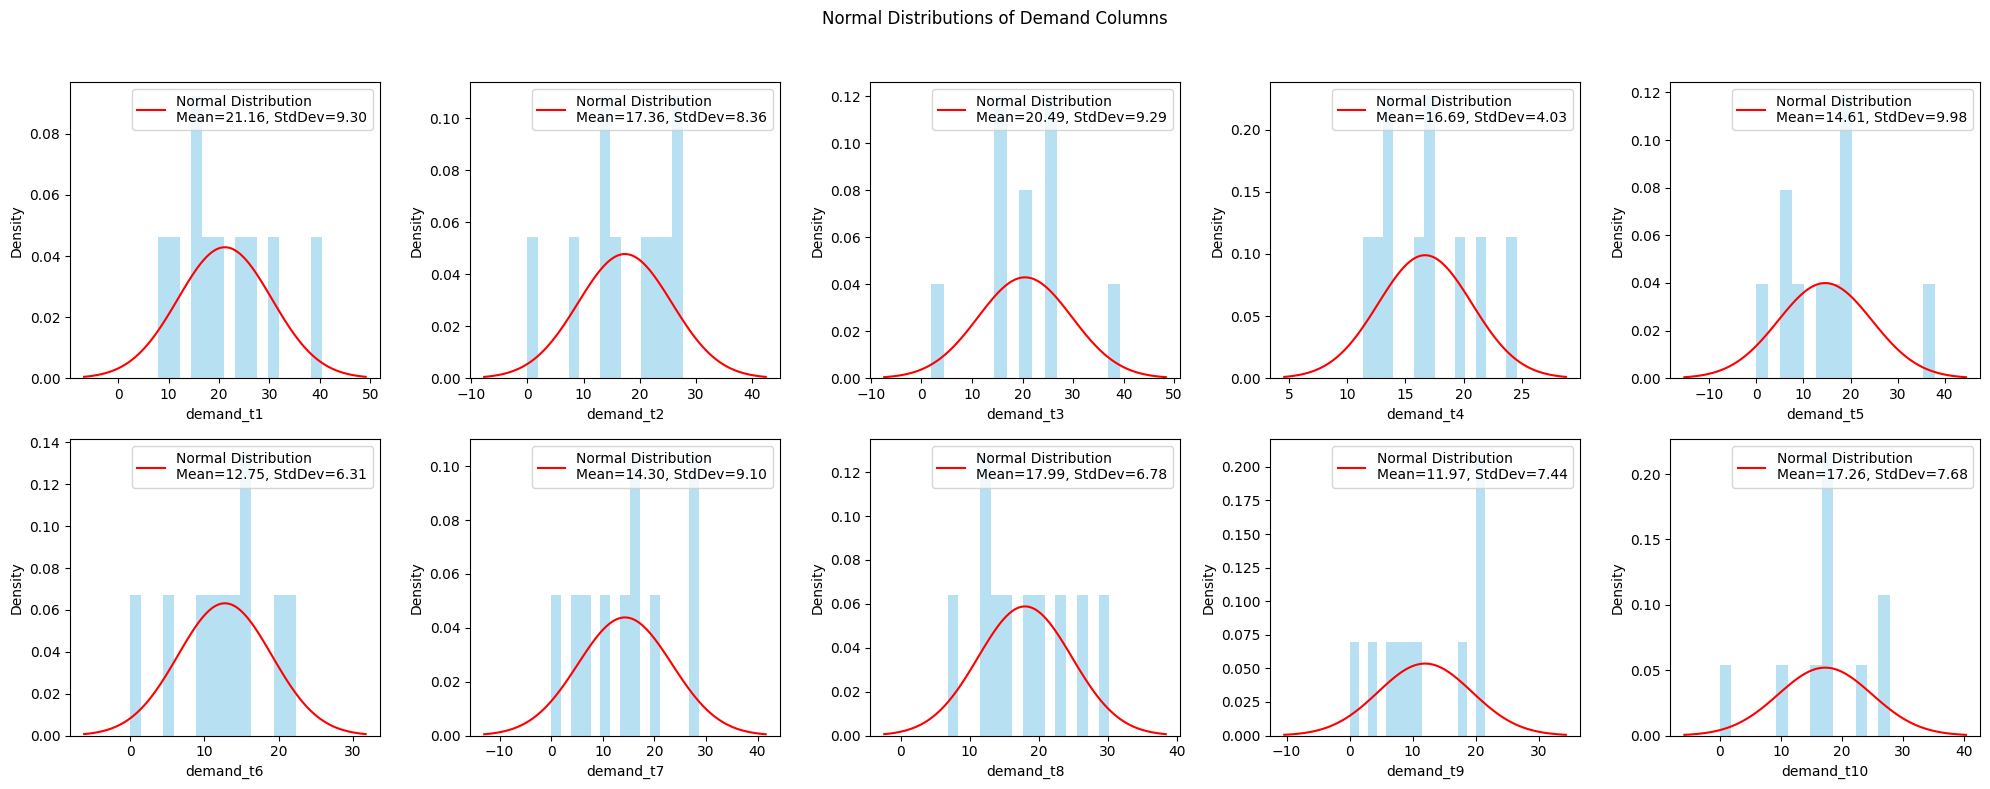

In [28]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [29]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,96.140563,10.264617,40.736347,18.597388,-24.738177,-8.542396,-6.193836,-5.921915,-44.215609,24.912251
demand_t2,10.264617,77.565928,56.828905,15.653934,-79.441084,-6.355782,-38.730581,29.935393,39.086048,30.661550
demand_t3,40.736347,56.828905,95.836592,20.679669,-77.526774,-42.020007,-75.783117,-13.109570,3.904690,4.766683
demand_t4,18.597388,15.653934,20.679669,18.043462,-17.041561,-1.013884,-3.572929,-5.409614,8.489074,24.699917
demand_t5,-24.738177,-79.441084,-77.526774,-17.041561,110.711226,17.558019,57.364147,-25.803296,-31.306909,-20.426421
demand_t6,-8.542396,-6.355782,-42.020007,-1.013884,17.558019,44.306775,56.623889,29.856691,4.650421,26.682686
demand_t7,-6.193836,-38.730581,-75.783117,-3.572929,57.364147,56.623889,91.935357,20.056550,-8.772045,30.483937
demand_t8,-5.921915,29.935393,-13.109570,-5.409614,-25.803296,29.856691,20.056550,51.073502,19.194949,21.385430
demand_t9,-44.215609,39.086048,3.904690,8.489074,-31.306909,4.650421,-8.772045,19.194949,61.571190,24.581263
demand_t10,24.912251,30.661550,4.766683,24.699917,-20.426421,26.682686,30.483937,21.385430,24.581263,65.465657


In [30]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,20.620983,13.296368,0.115533,11.686619,3.080553,1.657483,1.298607,14.466381,10.413499,26.190101
demand_t2,13.296368,18.896274,15.243063,0.077874,45.685961,0.257725,14.304491,25.237276,32.386760,33.311167
demand_t3,0.115533,15.243063,25.082200,7.688432,47.770608,27.557603,35.406669,13.864637,31.625998,12.381136
demand_t4,11.686619,0.077874,7.688432,18.084526,4.246874,2.410360,12.168514,26.358962,4.272762,14.404210
demand_t5,3.080553,45.685961,47.770608,4.246874,42.549469,4.737158,35.786848,46.436467,21.208886,14.123243
demand_t6,1.657483,0.257725,27.557603,2.410360,4.737158,8.643933,14.984895,2.312083,24.430560,19.131762
demand_t7,1.298607,14.304491,35.406669,12.168514,35.786848,14.984895,16.189334,17.176047,8.095468,0.753899
demand_t8,14.466381,25.237276,13.864637,26.358962,46.436467,2.312083,17.176047,21.240370,32.972218,13.594105
demand_t9,10.413499,32.386760,31.625998,4.272762,21.208886,24.430560,8.095468,32.972218,1.752210,4.705624
demand_t10,26.190101,33.311167,12.381136,14.404210,14.123243,19.131762,0.753899,13.594105,4.705624,15.834359


### Validate the corr matrix of damand_df is close to original setting


In [31]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.118865,0.424388,0.446518,-0.239783,-0.130885,-0.065882,-0.084511,-0.574690,0.314017
demand_t2,0.118865,1.000000,0.659125,0.418435,-0.857263,-0.108417,-0.458646,0.475611,0.565584,0.430281
demand_t3,0.424388,0.659125,1.000000,0.497299,-0.752645,-0.644845,-0.807357,-0.187381,0.050831,0.060179
demand_t4,0.446518,0.418435,0.497299,1.000000,-0.381288,-0.035859,-0.087725,-0.178200,0.254690,0.718669
demand_t5,-0.239783,-0.857263,-0.752645,-0.381288,1.000000,0.250694,0.568596,-0.343148,-0.379189,-0.239933
demand_t6,-0.130885,-0.108417,-0.644845,-0.035859,0.250694,1.000000,0.887204,0.627637,0.089037,0.495436
demand_t7,-0.065882,-0.458646,-0.807357,-0.087725,0.568596,0.887204,1.000000,0.292696,-0.116593,0.392937
demand_t8,-0.084511,0.475611,-0.187381,-0.178200,-0.343148,0.627637,0.292696,1.000000,0.342295,0.369840
demand_t9,-0.574690,0.565584,0.050831,0.254690,-0.379189,0.089037,-0.116593,0.342295,1.000000,0.387176
demand_t10,0.314017,0.430281,0.060179,0.718669,-0.239933,0.495436,0.392937,0.369840,0.387176,1.000000


In [32]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [33]:
demand_df_train, demand_df_test = (
    demand_df[: int(data_size * train_size)],
    demand_df[int(data_size * train_size) :],
)
print(f"demand_df_train size: {demand_df_train.shape}")
print(f"demand_df_test size: {demand_df_test.shape}")

demand_df_test.reset_index(drop=True, inplace=True)

demand_df_train size: (8, 10)
demand_df_test size: (2, 10)


In [34]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [35]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [36]:
Q_star = calculate_Q_star(demand_df_train, service_level=0.95)

mean of sum: 165.23025333702137
std of sum: 32.36898528744641
95.0 percentile of sum: 218.47249618781643


## Data3: Qk hat df


### Functions


In [ ]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [38]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [39]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    print(f"        mean_Y: {mean_Y}")
    print(f"        sd_Y: {sd_Y}")
    print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [40]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    print(f"mu_matrix: {mu_matrix}")
    print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [41]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            print(f"    x_observed: {x_observed}")
            print(f"    mu_cond: {mu_cond}")
            print(f"    sigma_cond: \n{sigma_cond}")
            print(f"    Qk_hat: {Qk_hat}")
            print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [42]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [43]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [44]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
        mean_Y: 69.23076923076923
        sd_Y: 4.260733053577301
    percentile_95_Y: 76.23905144741786
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

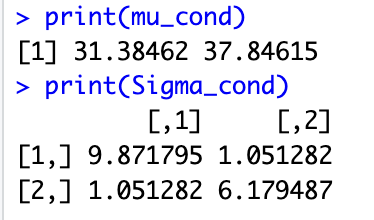
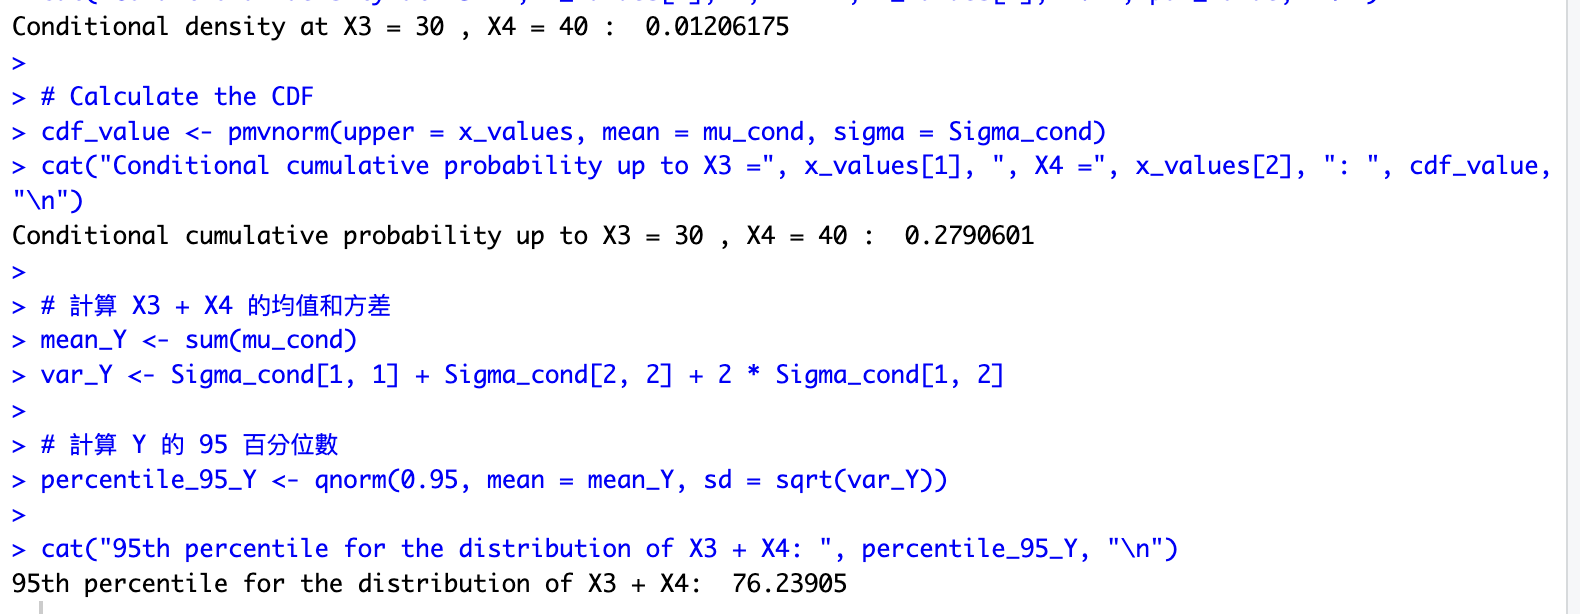


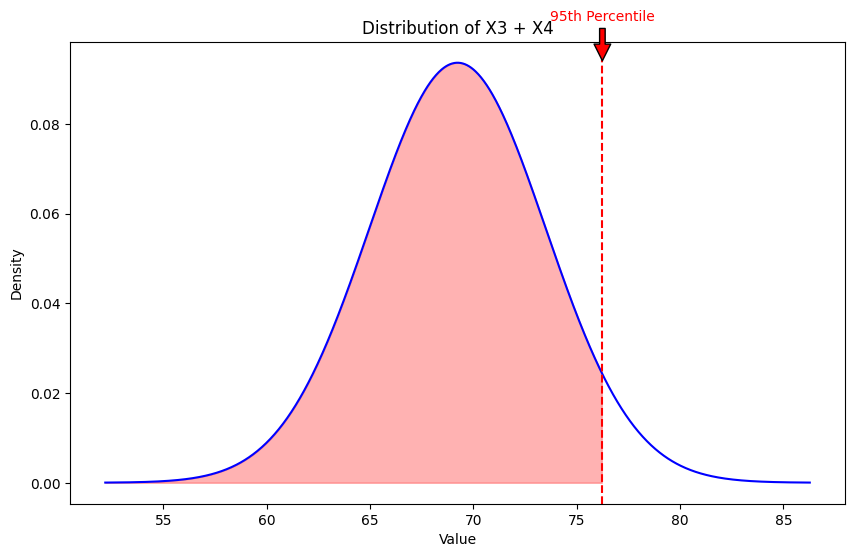

In [45]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


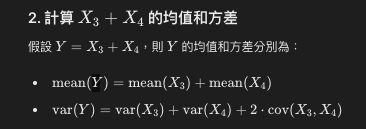


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [46]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.017454947339558
模擬計算的Y的方差: 2.9686649366161726


### Calculate Qk hat for 2~T-1 of demand_df_train


In [47]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,20.362071,0.000000,1.876173,13.829487,37.999804,15.730623,27.761683,12.674387,6.486290,18.042602
1,26.929636,14.523356,14.822453,16.152803,19.770065,19.908182,20.363275,23.823347,3.777147,15.516722
2,40.456521,27.668716,39.352082,24.551533,6.717207,4.817971,4.145474,12.307168,9.069881,26.554605
3,11.865725,26.270771,15.672362,11.333333,12.788370,15.638919,15.334353,30.165226,20.723089,17.027987
4,15.542084,8.367902,25.631245,13.318272,18.648704,0.000000,0.000000,6.820556,7.910891,0.000000
5,17.398939,23.395329,20.972842,19.657368,5.418654,9.827123,9.914197,15.753730,21.430474,18.154416
6,7.967888,24.191161,25.931141,16.830363,9.869894,11.482410,5.988287,19.309205,20.868307,17.680984
7,15.186240,14.882321,14.905961,21.696018,18.929439,22.269004,28.649604,17.942236,18.485201,27.802236


In [48]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

mu_matrix: [19.46363807 17.41244457 19.89553243 17.17114712 16.26776719 12.45927895
 14.01960902 17.34948188 13.59391018 17.59744393]
covariance_matrix: 
[[103.58110026   9.54311105  44.81612361  26.17491561  -7.59402669
  -14.63643563  -9.19498387 -19.93877915 -46.75107049  28.63966122]
 [  9.54311105  95.02175378  71.2379326   17.29631885 -93.40690293
   -9.02697434 -48.06498543  31.71125015  43.44235976  31.76039764]
 [ 44.81612361  71.2379326  120.31561685  27.08243938 -90.05983085
  -55.42555229 -97.68297733 -22.0098302    7.87034802   4.06677254]
 [ 26.17491561  17.29631885  27.08243938  20.33863134 -21.1835854
   -1.04209232  -2.88384288  -9.1980948    2.82472045  26.48506001]
 [ -7.59402669 -93.40690293 -90.05983085 -21.1835854  108.46519082
   27.19267698  73.15336678 -13.43951981 -43.21640849 -14.64162898]
 [-14.63643563  -9.02697434 -55.42555229  -1.04209232  27.19267698
   56.2906292   72.66888712  35.92744906   7.41678451  33.35886922]
 [ -9.19498387 -48.06498543 -97.68297

In [152]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

mu_matrix: [21.15597761 17.36169938 20.49433819 16.6911646  14.6058748  12.75118518
 14.29778438 17.98783966 11.97044257 17.25702768]
covariance_matrix: 
[[ 96.14056298  10.26461707  40.73634699  18.59738755 -24.73817681
   -8.54239627  -6.19383574  -5.92191451 -44.21560933  24.91225133]
 [ 10.26461707  77.56592803  56.8289046   15.6539339  -79.44108409
   -6.35578159 -38.73058139  29.93539343  39.08604835  30.66155043]
 [ 40.73634699  56.8289046   95.83659176  20.679669   -77.52677386
  -42.02000674 -75.78311723 -13.10957042   3.9046895    4.76668266]
 [ 18.59738755  15.6539339   20.679669    18.04346201 -17.04156093
   -1.0138843   -3.57292923  -5.4096141    8.48907415  24.69991681]
 [-24.73817681 -79.44108409 -77.52677386 -17.04156093 110.71122587
   17.55801863  57.36414689 -25.80329627 -31.30690946 -20.42642142]
 [ -8.54239627  -6.35578159 -42.02000674  -1.0138843   17.55801863
   44.30677505  56.62388936  29.85669074   4.65042111  26.6826862 ]
 [ -6.19383574 -38.73058139 -75.7831

In [153]:
Qk_hat_df

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,210.550037,176.082226,181.322999,174.122946,175.506441,160.047525,159.501821,155.701719
1,217.452240,205.520907,208.945500,195.913823,196.165307,196.375390,189.975577,182.257756
2,231.668363,238.815269,213.381362,211.542405,214.582957,203.635631,203.556894,199.352837
3,201.620775,211.465443,220.070605,190.649272,192.425743,182.349731,183.137725,182.494281
4,205.484456,185.499234,137.938700,119.847570,118.850039,105.746153,104.009727,102.884721
5,207.435923,211.629081,205.936790,206.005984,202.773169,180.333542,179.319279,166.986384
6,197.524330,204.656809,178.281923,170.646743,171.116385,169.704471,166.207365,159.891642
7,205.110480,195.808704,188.640151,204.165649,203.057229,207.143899,208.866618,206.691204
8,222.261383,220.437012,214.205781,195.866668,190.268836,185.070586,183.905256,185.050367
9,214.735965,200.944716,182.349024,154.810256,153.942407,155.792570,158.308492,144.487770


### Plot the distribuction


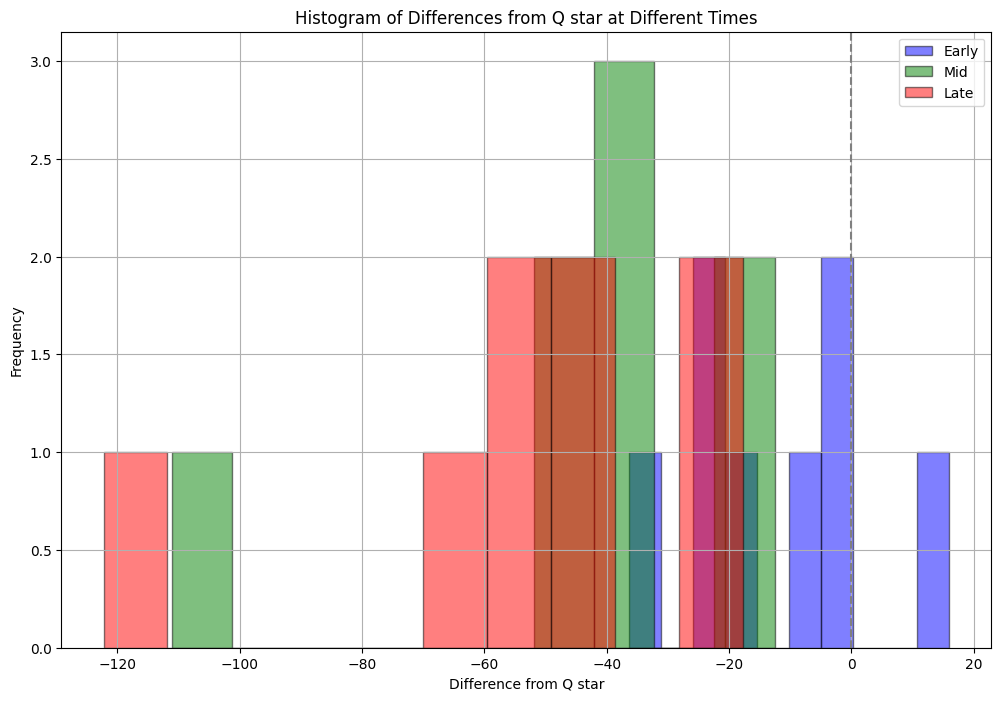

Q_star is: 218.47249618781643
Early bias: -11.608330080496145
Mid bias: -41.79525435568222
Late bias: -53.24224188795788


In [ ]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

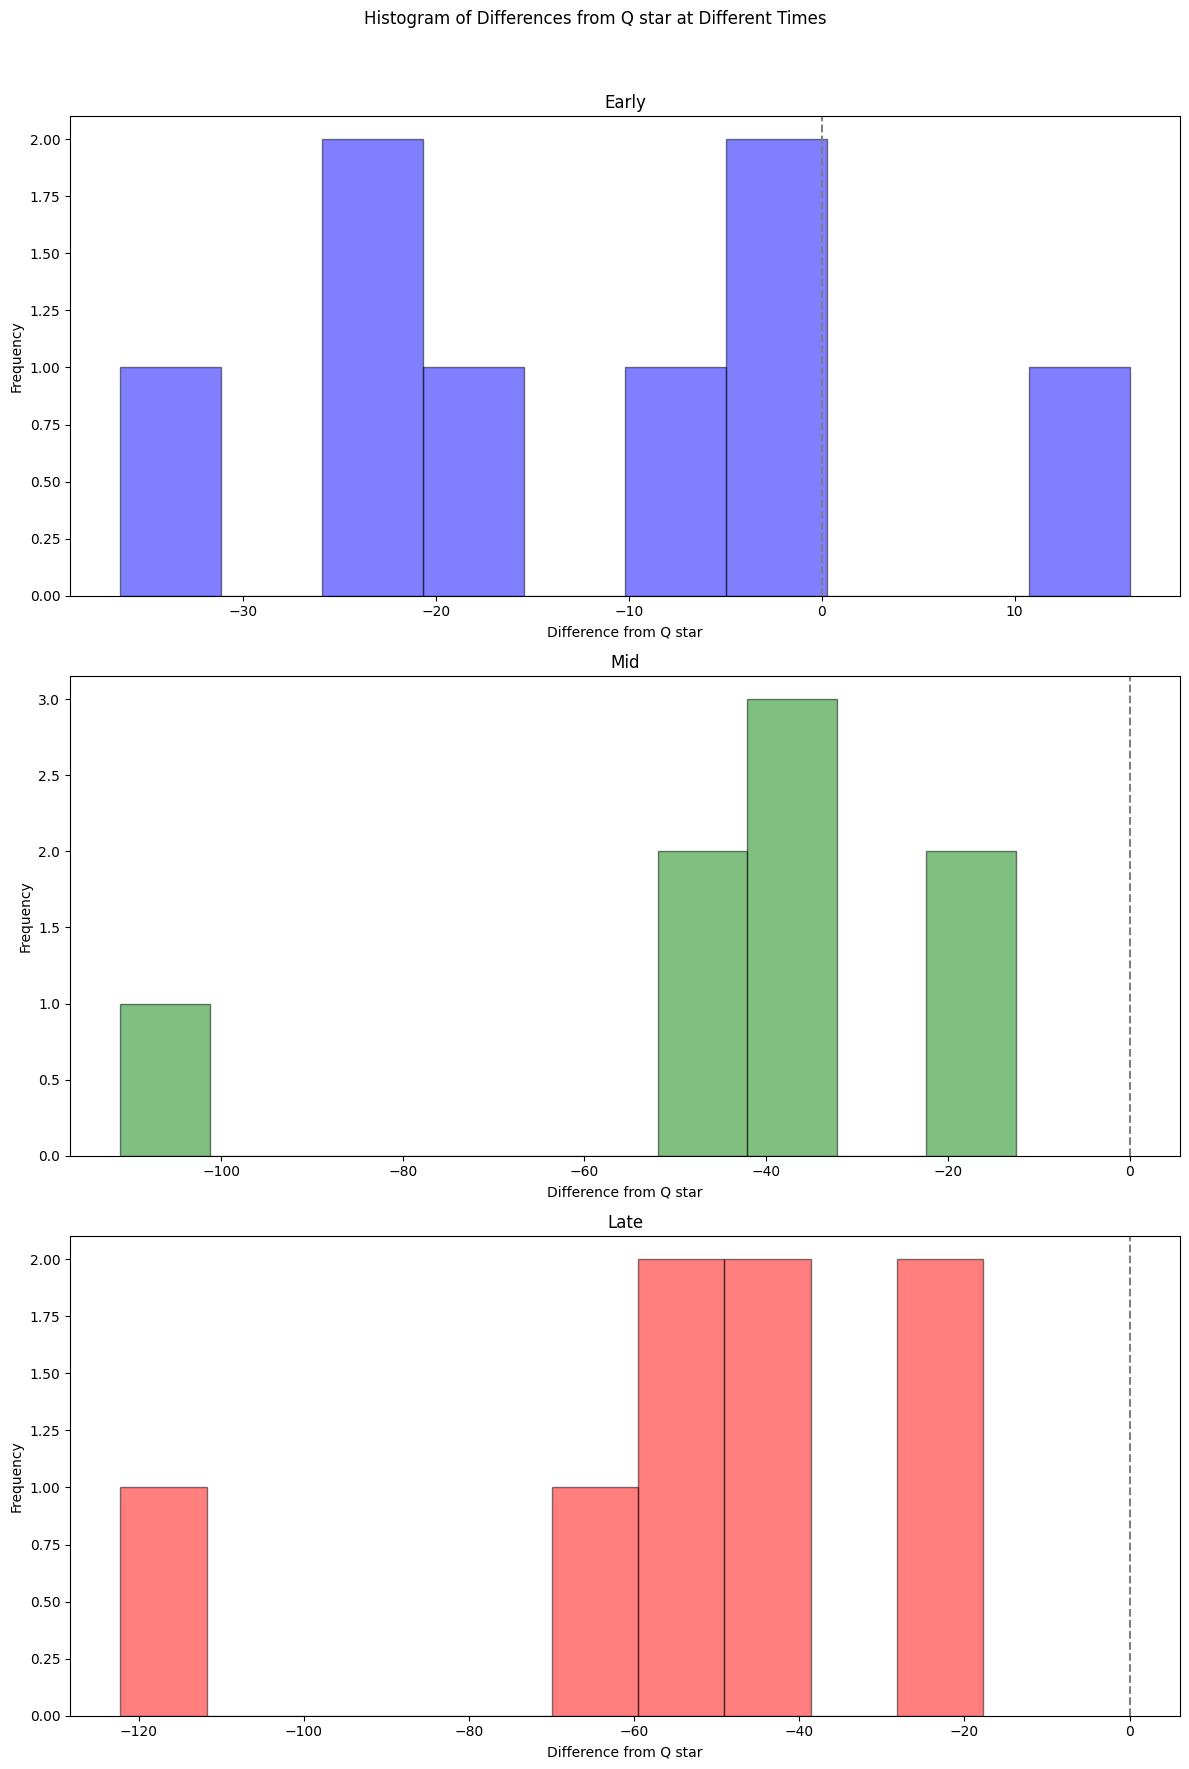

In [52]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## One-time Procurement


In [53]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## (1)Grid for Fixed F & Fixed Rk


In [ ]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": Q0,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
    }

    return result_df, stimulation_result

In [55]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    print(f"Q_star: {Q_star}")
    results_list = []
    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [ ]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        # betas = model.addVars(K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept")  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (assigned_R+1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(assigned_R+1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [ ]:
def grid_flexible_F_fixed_R(assigned_Ts, salvage_value, cost, price):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        # "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R,
            salvage_value,
            cost,
            price,
            Q_star,
            demand_df_train,
            Qk_hat_df,
            training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            # results_dict["beta_values"].append(beta_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (4)Grid for Fixed F & Flexible Rk(s6)


In [58]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        # alphas = model.addVars(features_num + 1, name="alphas")  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            # 指定 F 值
            model.addConstr(F_vars[i] == assigned_F)

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                # alpha_values = np.array([alpha.X for key, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [59]:
def grid_fixed_F_flexible_R(assigned_Fs, salvage_value, cost, price):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        # "alpha_values": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F,
            salvage_value,
            cost,
            price,
            Q_star,
            demand_df_train,
            Qk_hat_df,
            training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            # results_dict["alpha_values"].append(alpha_values)
            results_dict["beta_values"].append(beta_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

            print(f"beta_values: \n{beta_values}")

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [60]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [61]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [62]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None
        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [63]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


這是將 tau = beta + f 進行計算的部分


In [64]:
def __fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept
        # gamma = model.addVar(1, name="gamma")  # gamma

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            # model.addGenConstrMax(Q1_vars[i], [Q_hat_adjusteds[i]], 0.0, name=f"Q1_var_{i}")
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )  # 計算 Q1 = max(Q_hat_adjusted, 0) 的線性替代
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [65]:
def fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_3(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

### (7)Beta with softmax


In [66]:
def __fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)

            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                    print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [67]:
def fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_7(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
        )

# Testing Utils


## (1)Grid for Fixed F & Fixed Rk


In [68]:
# put best F and R into the model
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [69]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

## (4)Grid for Fixed F & Flexible Rk(s6)


In [70]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [71]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [72]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [73]:
# import alpha and beta
# put them to compute every R and F


def cal_test_fully_flexible_simple_beta_with_softmax_3(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

### (7)Beta with softmax


In [74]:
# import alpha and beta
# put them to compute every R and F


def cal_test_fully_flexible_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value)
            * Left_1s[i]  # Cost of leftover stock at salvage value
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    return results_df, stimulation_result

# Low Margin(P-C Small)


## Setting reasonable parameters


In [75]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411031830

In [76]:
model_prefix = "low"

salvage_value = 0
cost = 800
price = 1000

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.2


In [77]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 165.23025333702137
std of sum: 32.36898528744641
20.0 percentile of sum: 137.9878280098972
Q_star: 137.9878280098972


In [78]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,20.362071,0.000000,1.876173,13.829487,37.999804,15.730623,27.761683,12.674387,6.486290,18.042602
1,26.929636,14.523356,14.822453,16.152803,19.770065,19.908182,20.363275,23.823347,3.777147,15.516722
2,40.456521,27.668716,39.352082,24.551533,6.717207,4.817971,4.145474,12.307168,9.069881,26.554605
3,11.865725,26.270771,15.672362,11.333333,12.788370,15.638919,15.334353,30.165226,20.723089,17.027987
4,15.542084,8.367902,25.631245,13.318272,18.648704,0.000000,0.000000,6.820556,7.910891,0.000000
5,17.398939,23.395329,20.972842,19.657368,5.418654,9.827123,9.914197,15.753730,21.430474,18.154416
6,7.967888,24.191161,25.931141,16.830363,9.869894,11.482410,5.988287,19.309205,20.868307,17.680984
7,15.186240,14.882321,14.905961,21.696018,18.929439,22.269004,28.649604,17.942236,18.485201,27.802236


In [79]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df = make_Qk_hat_df(demand_df_train, T, service_lv, mu_matrix, covariance_matrix)
Qk_hat_df

mu_matrix: [19.46363807 17.41244457 19.89553243 17.17114712 16.26776719 12.45927895
 14.01960902 17.34948188 13.59391018 17.59744393]
covariance_matrix: 
[[103.58110026   9.54311105  44.81612361  26.17491561  -7.59402669
  -14.63643563  -9.19498387 -19.93877915 -46.75107049  28.63966122]
 [  9.54311105  95.02175378  71.2379326   17.29631885 -93.40690293
   -9.02697434 -48.06498543  31.71125015  43.44235976  31.76039764]
 [ 44.81612361  71.2379326  120.31561685  27.08243938 -90.05983085
  -55.42555229 -97.68297733 -22.0098302    7.87034802   4.06677254]
 [ 26.17491561  17.29631885  27.08243938  20.33863134 -21.1835854
   -1.04209232  -2.88384288  -9.1980948    2.82472045  26.48506001]
 [ -7.59402669 -93.40690293 -90.05983085 -21.1835854  108.46519082
   27.19267698  73.15336678 -13.43951981 -43.21640849 -14.64162898]
 [-14.63643563  -9.02697434 -55.42555229  -1.04209232  27.19267698
   56.2906292   72.66888712  35.92744906   7.41678451  33.35886922]
 [ -9.19498387 -48.06498543 -97.68297

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,140.684868,117.885227,140.032085,144.934237,157.381193,153.775933,154.763120,154.763120
1,147.953598,145.697026,167.366257,165.350426,162.392218,175.576972,175.586987,175.586987
2,162.924639,178.230883,173.313972,180.690499,192.398813,192.762217,195.641155,195.641155
3,131.281436,148.412248,175.286268,160.383190,169.408873,171.420101,176.820134,176.820134
4,135.350290,125.556932,96.697606,90.107033,88.284824,91.910029,96.239654,96.239654
5,137.405386,149.539677,162.541202,178.543378,164.287731,160.595519,161.923072,161.923072
6,126.967458,141.558857,134.083514,143.552159,158.058131,162.221685,160.119640,160.119640
7,134.956455,134.826626,145.706412,178.763266,187.210970,194.946917,200.748260,200.748260


## Strategies


### One-time procurement strategy


In [80]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(Q_star, demand_df_train, cost, price, salvage_value)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/8 with initial inventory Q_star=137.9878280098972
--------------------------------------------------
Day 1
Demand      : 20.362071289958774
Sales       : 20.362071289958774
Loss        : 0
Left        : 117.62575671993844
Inventory   : 117.62575671993844
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 0.0
Sales       : 0.0
Loss        : 0
Left        : 117.62575671993844
Inventory   : 117.62575671993844
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 1.876173447937692
Sales       : 1.876173447937692
Loss        : 0
Left        : 115.74958327200075
Inventory   : 115.74958327200075
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 13.829486929724528
Sales       : 13.829486929724528
Loss        : 0
Left        : 101.92009634227622
Inventory   : 101.9200963

In [81]:
baseline_stimulation_df

,losses,lefts,operation_profits,profits
0,16.775292,0.000000,27597.565602,24242.507107
1,37.599159,0.000000,27597.565602,20077.733739
2,57.653328,0.000000,27597.565602,16066.900012
3,38.832307,0.000000,27597.565602,19831.104226
4,0.000000,41.748173,19247.930974,-14150.607536
5,23.935244,0.000000,27597.565602,22810.516724
6,22.131813,0.000000,27597.565602,23171.203093
7,62.760432,0.000000,27597.565602,15045.479161


### (1)Grid for Fixed F & Fixed Rk


In [82]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
)
results_df_1

Q_star: 137.9878280098972




這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 137.9878280098972
期初庫存 Q0: 13.798782800989722
重新估計量 Qk_hat: 140.6848678193212
訂貨量 Q1 為 126.88608501833147

第一階段：期初庫存 Q0: 13.798782800989722，需求量為 20.362071289958774，Sold_0 為 13.798782800989722，Left_0 為 0.0，Lost_0 為 6.563288488969052
第二階段：期初庫存 Q1+left_0 為 126.88608501833147，需求量為 134.40104919337404，Sold_1 為 126.88608501833147，Left_1 為 0.0，Lost_1 為 7.514964175042564

統計結果：Sold 為 140.6848678193212, Lost 為 14.078252664011616 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 2815.650532802323，Profit 為 25321.323031061915
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 137.9878280098972
期初庫存 Q0: 13.798782800989722
重新估計量 Qk_hat: 147.95359844550143
訂貨量 Q1 為 134.1548156445117

第一階段：期初庫存 Q0: 13.798782800989722，需求量為 26.929636173694064，Sold_0 為 13.798782800989722，Left_0 為 0.0，Lost_0 為 13.130853372704342
第二階段：期初庫存 Q1+left_0 為 134.1548156445117，需求量為 148.65735115270598，Sold_1 為 134.1548156445117，Left_1 為 0.0，Lost_1 為 

,R(T),F,Q0,average_profits,average_losses,average_lefts,average_operation_profits
53,7,0.9,124.189045,26746.246867,4.112640,5.818435,32223.522758
24,4,0.7,96.591480,26543.903047,15.986349,0.134510,29848.780904
23,4,0.6,82.792697,26190.287276,16.281029,0.429190,29789.844942
44,6,0.9,124.189045,26083.279287,6.345231,5.530849,31777.004567
52,7,0.8,110.390262,25800.374993,6.050765,6.031712,31835.897732
...,...,...,...,...,...,...,...
55,8,0.2,27.597566,-73864.171049,89.091852,89.091851,15227.680317
65,9,0.3,41.396348,-78125.009920,92.642551,92.642550,14517.540502
54,8,0.1,13.798783,-90422.710410,102.890635,102.890634,12467.923757
64,9,0.2,27.597566,-94683.549281,106.441334,106.441333,11757.783942


In [83]:
stimulation_results_df_1

,R(T),F,profits,losses,lefts,operation_profits
0,7,0.9,30557.749168,0.987187,0.000000,30755.186632
1,7,0.9,35113.391445,0.010015,0.000000,35115.394455
2,7,0.9,18181.401396,19.374984,16.496045,35253.234385
3,7,0.9,33204.013534,5.400034,0.000000,34284.020256
4,7,0.9,-3111.581295,0.000000,27.949390,19247.930974
5,7,0.9,31853.593174,1.327553,0.000000,32119.103827
6,7,0.9,30342.292718,0.000000,2.102044,32023.928111
7,7,0.9,37829.114799,5.801343,0.000000,38989.383421


In [84]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 137.9878280098972
Maximum Profit: 26746.24686722893


In [85]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

,R(T),F,average_profits
53,7,0.9,26746.246867
24,4,0.7,26543.903047
23,4,0.6,26190.287276


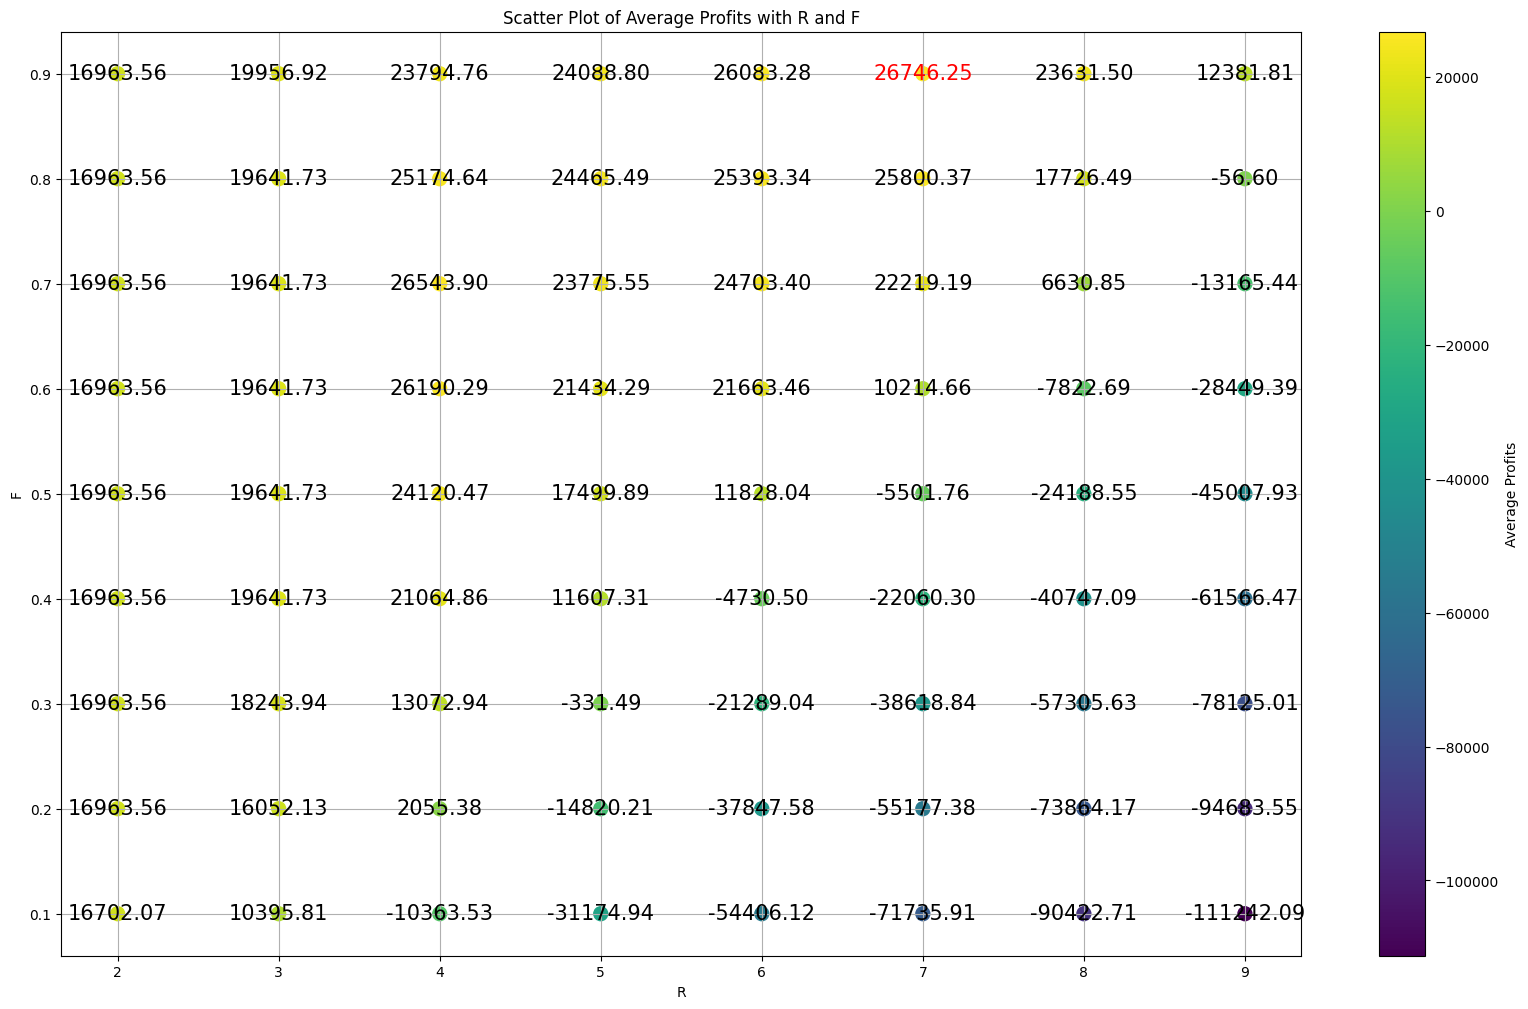

In [86]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

plt.show()

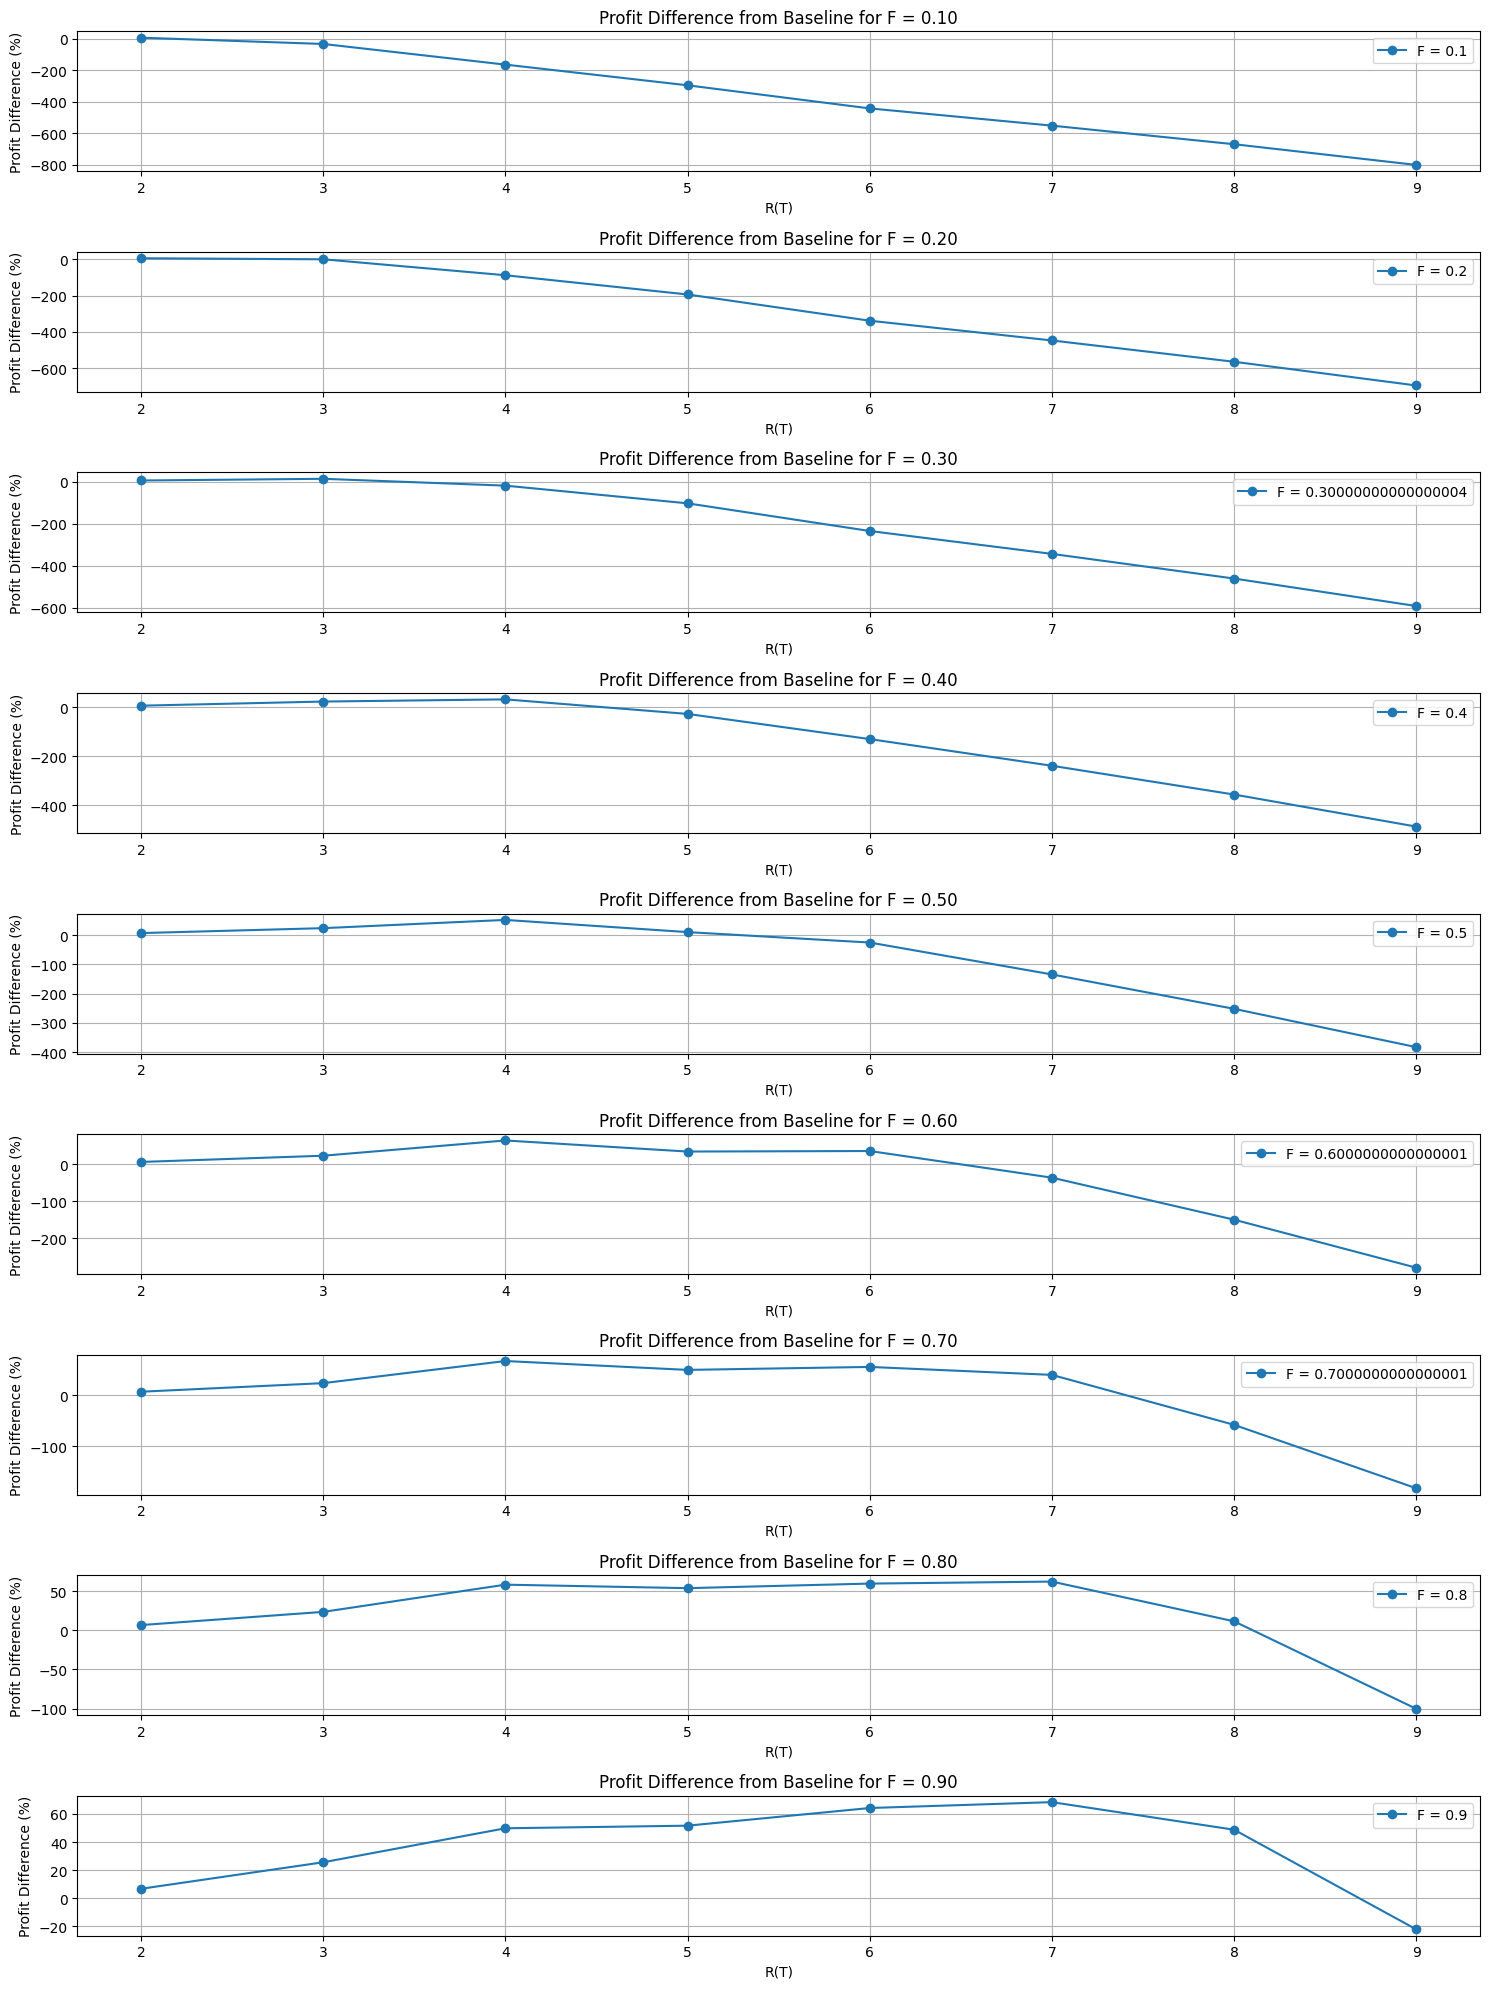

In [87]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(assigned_Fs):
    plt.subplot(len(assigned_Fs), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

### (2)Grid for Fixed Rk & Flexible F


In [88]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts, salvage_value, cost, price
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 208 rows, 211 columns and 680 nonzeros
Model fingerprint: 0xaf635105
Model has 8 general constraints
Variable types: 147 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 134 rows and 111 columns
Presolve time: 0.00s
Presolved: 74 rows, 100 columns, 371 nonzeros
Variable types: 76 continuous, 24 integer (22 binary)

Root relax

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/404395556.py:192: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/404395556.py:192: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/404395556.py:192: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

,R(T),R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,F_vars,Q0_vars,Q1_vars
0,2,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,115.087792,33046.050667,29134.987190,"[0.0, 0.0, 2.065739925773621]","[0.726356732438781, 0.7790332196150247, 0.8875...","[100.22838786959343, 107.49710192223452, 122.4...","[40.456479949727765, 40.45649652326691, 40.456..."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1]",0.0,124.334425,33046.050667,28892.457357,"[0.0, 0.0, 6.475663576628612]","[0.9981436774907717, 0.9980367129326929, 0.998...","[137.73167809876293, 137.7169182917196, 137.77...","[0.0, 7.980107249094431, 40.456385201472614, 1..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2]",0.0,98.896340,33046.050667,28842.038674,"[0.07209790045473738, 0.05167611808908563, 0.0]","[0.9976567298017597, 0.9984037440759171, 0.998...","[137.6644852448017, 137.7675641219851, 137.723...","[2.367599655811887, 29.59869331121564, 35.5909..."


In [89]:
if results_df_2 is not None:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/low_s2_10_202411031830.pkl


In [90]:
stimulation_results_df_2

,R,F,profits,losses,lefts,operation_profits
0,0,0.726357,30952.624097,0.0,93.944569,30952.624097
1,0,0.779033,35117.397465,0.0,108.200855,35117.397465
2,0,0.887528,39128.231192,0.0,114.728114,39128.231192
3,0,0.658210,35364.026978,0.0,124.497955,35364.026978
4,0,0.687697,-12040.576847,0.0,118.462374,19247.930974
5,0,0.702590,32384.614480,0.0,104.067662,32384.614480
6,0,0.626947,32023.928111,0.0,111.695311,32023.928111
7,0,0.684843,40149.652043,0.0,145.105499,40149.652043


In [91]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

,R(T),average_profits
0,2,29134.987190
1,3,28892.457357
2,4,28842.038674


### (4)Grid for Fixed F & Flexible Rk


In [92]:
assigned_Fs = np.arange(0.1, 1.0, 0.1)

results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = grid_fixed_F_flexible_R(
    assigned_Fs, salvage_value, cost, price
)
results_df_4

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 392 rows, 464 columns and 1192 nonzeros
Model fingerprint: 0x0abd37fe
Model has 56 quadratic constraints
Model has 128 general constraints
Variable types: 400 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 160 rows and 12

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/3506354902.py:242: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0       576         -         0       424         -           0s
        6         6         6         1         1         1           0s

IIS computed: 6 constraints, 1 bounds
IIS runtime: 0.01 seconds (0.00 work units)
導致不可行的約束： R98
導致不可行的約束： Q0_upper_bound_2
導致不可行的約束： Ensure_only_one_R_true_2
導致不可行的約束： Define_Q_hat_2
導致不可行的約束： Adjust_Q_hat_2
導致不可行的約束： Constr_Q1_ge_Q_hat_adjusted_2
導致不可行的變量： Q1_var[2], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is F=0.4 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F

,R(T),average_losses,average_lefts,average_operation_profits,average_profits,beta_values,F_vars,Q0_vars,Q1_vars
0,"[9, 6, 2, 5, 9, 9, 9, 4]",0.755648,55.712391,32894.921086,29344.334196,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]","[124.1890452089075, 124.1890452089075, 124.189...","[30.57407477027796, 38.20317305187935, 38.7355..."


In [93]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4", beta_values=results_df_4.iloc[0]["beta_values"]
    )

Model parameters saved as models/low_s4_10_202411031830.pkl


In [94]:
stimulation_results_df_4

,R(T),F,profits,losses,lefts,operation_profits
0,9,0.9,23698.404599,6.045183,6.045183,29743.587446
1,6,0.9,35117.397465,0.000000,45.185500,35117.397465
2,2,0.9,39128.231192,0.000000,116.449041,39128.231192
3,5,0.9,35364.026978,0.000000,75.483800,35364.026978
4,9,0.9,-3111.581295,0.000000,63.809672,19247.930974
5,9,0.9,32384.614480,0.000000,1.850864,32384.614480
6,9,0.9,32023.928111,0.000000,2.618696,32023.928111
7,4,0.9,40149.652043,0.000000,134.256371,40149.652043


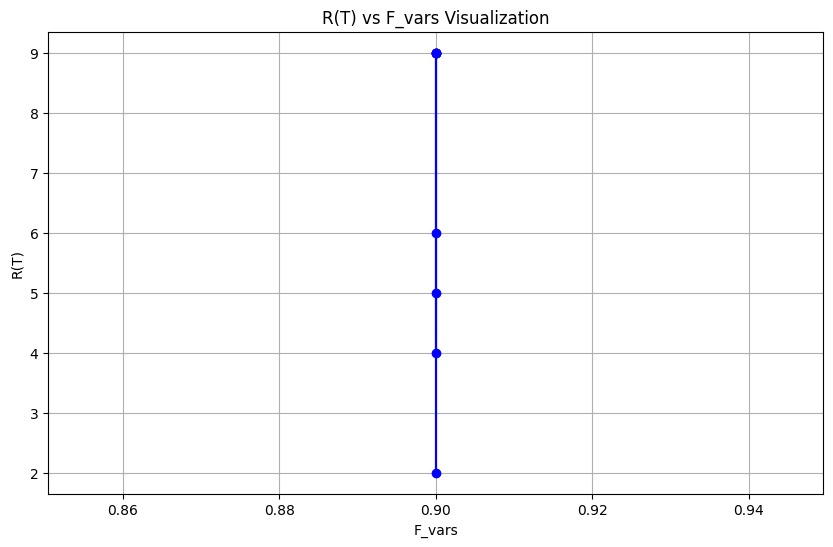

In [95]:
if results_df_4 is not None:

    r_values = results_df_4["R(T)"].explode().values
    f_values = results_df_4["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)
    plt.show()

else:
    print("results_df_4 is None")

### (3)Fully flexible F & Rk


#### (5)Simple beta with softmax


In [96]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 392 rows, 507 columns and 1120 nonzeros
Model fingerprint: 0x745ddd7c
Model has 64 quadratic constraints
Model has 144 general constraints
Variable types: 443 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 87 rows and 9939 columns
Presolve time: 0.04s
Presolved: 2911 rows, 11022 columns, 37997 nonzeros
Presolved model has 72 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/1898876225.py:242: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     0 264368.405    0  578          - 264368.405      -     -    0s
     0     0 264368.405    0  578          - 264368.405      -     -    0s
     0     2 264368.405    0  578          - 264368.405      -     -    0s
  7067  2957 232955.369  277    7          - 243731.038      -  34.0    5s
  7916  3415 243731.038   51  725          - 243731.038      -  51.9   11s
 10085  4159 infeasible  211               - 243731.038      -  76.7   15s
*10356  2430             263    243731.03758 243731.038  0.00%  76.9   15s

Cutting planes:
  RLT: 4

Explored 10512 nodes (812387 simplex iterations) in 15.48 seconds (33.08 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 243731 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 2.437310375765e+05, best bound 2.437310375765e+05, gap 0.0000%

model.sta

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,30466.379697,0.0,81.889978,33046.050667,"[0.024338472395502377, 0.0, 0.0]","[[-0.08949069026857615], [-0.08949051923568178..."


In [97]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
    )

Model parameters saved as models/low_s5_10_202411031830.pkl


In [98]:
stimulation_results_df_5

,R(T),R,F,f_values,Q0_vars,Q1_vars,profits,losses,lefts,operation_profits
0,7,5,0.886586,2.080651,122.338068,32.425052,30952.624097,0.0,32.539909,30952.624097
1,3,1,0.889492,2.121144,122.739129,40.456521,35117.397465,0.0,93.677474,35117.397465
2,2,0,0.887528,2.093781,122.468118,40.456521,39128.231192,0.0,114.728114,39128.231192
3,2,0,0.886517,2.079694,122.328594,40.456521,35364.026978,0.0,124.497888,35364.026978
4,7,5,0.884399,2.050189,122.036365,0.000000,-1389.436788,0.0,66.324867,19247.930974
5,3,1,0.880797,2.104279,121.539269,28.000408,32384.614480,0.0,93.128397,32384.614480
6,9,7,0.881022,2.053580,121.570349,38.549291,32023.928111,0.0,0.000000,32023.928111
7,3,1,0.880797,2.164122,121.539274,40.456521,40149.652043,0.0,130.223178,40149.652043


#### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [99]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 392 rows, 475 columns and 1216 nonzeros
Model fingerprint: 0x1beedd1d
Model has 56 quadratic constraints
Model has 136 general constraints
Variable types: 411 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 79 rows and 8722 columns
Presolve time: 0.04s
Presolved: 695 rows, 9197 columns, 28029 nonzeros
Presolved model has 64 SO

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/3644731949.py:254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,28899.896065,0.0,57.989523,33046.050667,"[0.0, 3.2943724563735373, 0.053659734298834076]","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [100]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
    )

Model parameters saved as models/low_s6_10_202411031830.pkl


In [101]:
stimulation_results_df_6

,R(T),R,F,f_values,Q0_vars,Q1_vars,profits,losses,lefts,operation_profits
0,9,7,0.999952,9.936777,137.981155,16.781965,30952.624097,0.0,7.746926,30952.624097
1,6,4,0.999952,9.936777,137.981155,37.605832,35117.397465,0.0,45.782841,35117.397465
2,4,2,0.962820,3.348032,132.857451,40.456521,39128.231192,0.0,47.707316,39128.231192
3,3,1,0.997923,6.642405,137.701223,39.118912,35364.026978,0.0,99.564727,35364.026978
4,5,3,0.997923,6.642405,137.701201,0.000000,-13921.305847,0.0,116.303244,19247.930974
5,9,7,0.997923,6.642405,137.701223,24.221849,32384.614480,0.0,15.363041,32384.614480
6,9,7,0.997923,6.642405,137.701223,22.418417,32023.928111,0.0,16.130874,32023.928111
7,4,2,0.962820,3.348032,132.857451,40.456521,40149.652043,0.0,115.317217,40149.652043


#### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [102]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_3

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 392 rows, 475 columns and 1272 nonzeros
Model fingerprint: 0xc1557ecb
Model has 56 quadratic constraints
Model has 136 general constraints
Variable types: 411 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 135 rows and 8778 columns
Presolve time: 0.04s
Presolved: 751 rows, 9253 columns, 28197 nonzeros
Presolved model has 64 S

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2081417320.py:254: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     0 264368.405    0   77          - 264368.405      -     -    0s
     0     0 264368.405    0   80          - 264368.405      -     -    0s
     0     0 264368.405    0   82          - 264368.405      -     -    0s
     0     0 264368.405    0   85          - 264368.405      -     -    0s
     0     0 264368.405    0   81          - 264368.405      -     -    0s
     0     0 264368.405    0   81          - 264368.405      -     -    0s
     0     2 264368.405    0   81          - 264368.405      -     -    0s
H 3183  1421                    232955.49300 260292.694  11.7%  17.2    4s

Cutting planes:
  Gomory: 1
  Implied bound: 2
  Projected implied bound: 1
  MIR: 2
  Flow cover: 3
  RLT: 3
  Relax-and-lift: 1

Explored 3183 nodes (70565 simplex iterations) in 4.23 seconds (5.47 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 232955 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,29119.436624,0.0,87.011451,33046.050667,"[2.438146502480724e-06, 2.112109215950598e-06,...","[[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0..."


In [103]:
if results_df_3 is not None:
    save_model_parameters(
        f"{model_prefix}_s3",
        alpha_values=results_df_3.iloc[0]["alpha_values"],
        beta_values=results_df_3.iloc[0]["beta_values"],
    )

Model parameters saved as models/low_s3_10_202411031830.pkl


In [104]:
stimulation_results_df_3

,R(T),R,F,f_values,Q0_vars,Q1_vars,profits,losses,lefts,operation_profits
0,3,1,0.982014,3.999996,135.505950,0.000000,30952.624097,0.0,134.401049,30952.624097
1,6,4,0.952574,4.000000,131.443641,40.456521,35117.397465,0.0,42.932152,35117.397465
2,2,0,0.887528,3.999993,122.468118,40.456521,39128.231192,0.0,114.728114,39128.231192
3,5,3,0.982014,3.999994,135.505924,24.877266,35364.026978,0.0,86.800679,35364.026978
4,8,6,0.982013,3.999991,135.505795,0.000000,-12164.981369,0.0,93.263728,19247.930974
5,9,7,0.952574,3.999996,131.443641,30.479431,32384.614480,0.0,9.105460,32384.614480
6,5,3,0.982014,3.999991,135.505950,8.046209,32023.928111,0.0,77.152878,32023.928111
7,3,1,0.982014,4.000000,135.505950,32.972150,40149.652043,0.0,137.707549,40149.652043


#### (7)Beta with softmax


In [105]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 2000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 392 rows, 499 columns and 1248 nonzeros
Model fingerprint: 0x0a96a727
Model has 64 quadratic constraints
Model has 144 general constraints
Variable types: 435 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 151 rows and 10027 columns
Presolve time: 0.05s
Presolved: 1991 rows, 10854 columns, 35317 nonzeros
Presolved model has 7

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/3059651940.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     2 264368.405    0  153          - 264368.405      -     -    0s
  3394  1394 236816.232   30  393          - 243731.038      -  26.2    5s
  5254  2348 infeasible  103               - 243731.038      -  36.7   10s
 11914  5311 243731.038   79  530          - 243731.038      -  41.6   15s
*17185  4603             518    233079.89752 243731.038  4.57%  38.0   18s

Cutting planes:
  RLT: 2

Explored 17763 nodes (671509 simplex iterations) in 19.01 seconds (27.84 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 233080 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 2.330798975180e+05, best bound 2.437310375765e+05, gap 4.5697%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 137.9878280098972
Alphas va

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,29134.98719,0.0,133.599395,33046.050667,"[0.024338472395502377, 0.0, 0.0]","[[0.0, 0.0894717835347194, -0.2684342573380149..."


In [106]:
if results_df_7 is not None:
    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
    )

Model parameters saved as models/low_s7_10_202411031830.pkl


In [107]:
results_df_7

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,29134.98719,0.0,133.599395,33046.050667,"[0.024338472395502377, 0.0, 0.0]","[[0.0, 0.0894717835347194, -0.2684342573380149..."


In [108]:
stimulation_results_df_7

,R(T),R,F,f_values,Q0_vars,Q1_vars,profits,losses,lefts,operation_profits
0,2,0,0.880797,2.080651,121.539277,19.145591,30952.624097,0.0,115.255458,30952.624097
1,2,0,0.779033,2.121144,107.497077,40.456521,35117.397465,0.0,108.200830,35117.397465
2,2,0,0.887528,2.093781,122.468118,40.456521,39128.231192,0.0,114.728114,39128.231192
3,2,0,0.886517,2.079694,122.328594,8.952842,35364.026978,0.0,156.001568,35364.026978
4,2,0,0.884399,2.050189,122.036365,13.313925,-12040.576847,0.0,145.604915,19247.930974
5,2,0,0.888282,2.104279,122.572088,14.833298,32384.614480,0.0,129.690836,32384.614480
6,2,0,0.880797,2.053580,121.539274,5.428184,32023.928111,0.0,146.723569,32023.928111
7,2,0,0.880797,2.164122,121.539278,32.972150,40149.652043,0.0,152.589870,40149.652043


## Analysis


### 單次進貨策略


In [109]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 15886.854565824811


### 策略一


In [110]:
# 策略一
results_df_1

,R(T),F,Q0,average_profits,average_losses,average_lefts,average_operation_profits,baseline_profit,profit_diff_percent
53,7,0.9,124.189045,26746.246867,4.112640,5.818435,32223.522758,15886.854566,68.354577
24,4,0.7,96.591480,26543.903047,15.986349,0.134510,29848.780904,15886.854566,67.080922
23,4,0.6,82.792697,26190.287276,16.281029,0.429190,29789.844942,15886.854566,64.855083
44,6,0.9,124.189045,26083.279287,6.345231,5.530849,31777.004567,15886.854566,64.181520
52,7,0.8,110.390262,25800.374993,6.050765,6.031712,31835.897732,15886.854566,62.400775
...,...,...,...,...,...,...,...,...,...
55,8,0.2,27.597566,-73864.171049,89.091852,89.091851,15227.680317,15886.854566,-564.938926
65,9,0.3,41.396348,-78125.009920,92.642551,92.642550,14517.540502,15886.854566,-591.758829
54,8,0.1,13.798783,-90422.710410,102.890635,102.890634,12467.923757,15886.854566,-669.166854
64,9,0.2,27.597566,-94683.549281,106.441334,106.441333,11757.783942,15886.854566,-695.986757


In [111]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：-3326.7455612996923
策略1最佳策略在：R=7.0, F=0.9
策略1最佳策略之下最大利潤為：26746.24686722893


### 策略二


In [112]:
# 策略二
results_df_2

,R(T),R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,F_vars,Q0_vars,Q1_vars
0,2,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,115.087792,33046.050667,29134.987190,"[0.0, 0.0, 2.065739925773621]","[0.726356732438781, 0.7790332196150247, 0.8875...","[100.22838786959343, 107.49710192223452, 122.4...","[40.456479949727765, 40.45649652326691, 40.456..."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1]",0.0,124.334425,33046.050667,28892.457357,"[0.0, 0.0, 6.475663576628612]","[0.9981436774907717, 0.9980367129326929, 0.998...","[137.73167809876293, 137.7169182917196, 137.77...","[0.0, 7.980107249094431, 40.456385201472614, 1..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2]",0.0,98.896340,33046.050667,28842.038674,"[0.07209790045473738, 0.05167611808908563, 0.0]","[0.9976567298017597, 0.9984037440759171, 0.998...","[137.6644852448017, 137.7675641219851, 137.723...","[2.367599655811887, 29.59869331121564, 35.5909..."


In [113]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：28956.49440695035
策略2最佳策略在：R=2, F為彈性
策略2最佳策略之下最大利潤為：29134.98718974949


### 策略三


In [114]:
# 策略三
results_df_3

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,29119.436624,0.0,87.011451,33046.050667,"[2.438146502480724e-06, 2.112109215950598e-06,...","[[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0..."


In [115]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

策略3最佳策略在：
R=3.0, 
F=0.9820137900379085
策略3最佳策略之下最大利潤(Avg profit)為：40149.65204304685


### 策略四


In [116]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = stimulation_results_df_4.loc[
        stimulation_results_df_4["profits"].idxmax()
    ]
    max_profit_for_s4 = max_profit_row["profits"]

    print(f"策略4最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

策略4最佳策略在：
R=4.0, 
F=0.9
策略4最佳策略之下最大利潤(Avg profit)為：40149.65204304688


### 策略五


In [117]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

策略5最佳策略在：
R=3.0, 
F=0.8807970622010741
策略5最佳策略之下最大利潤(Avg profit)為：40149.65204304685


### 策略六


In [118]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略在：
R=4.0, 
F=0.962820077303972
策略6最佳策略之下最大利潤(Avg profit)為：40149.652043046844


### 策略七


In [119]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

策略7最佳策略在：
R=2.0, 
F=0.8807970975417098
策略7最佳策略之下最大利潤(Avg profit)為：40149.65204304685


### 比較&分析


#### 不同策略 Scatter


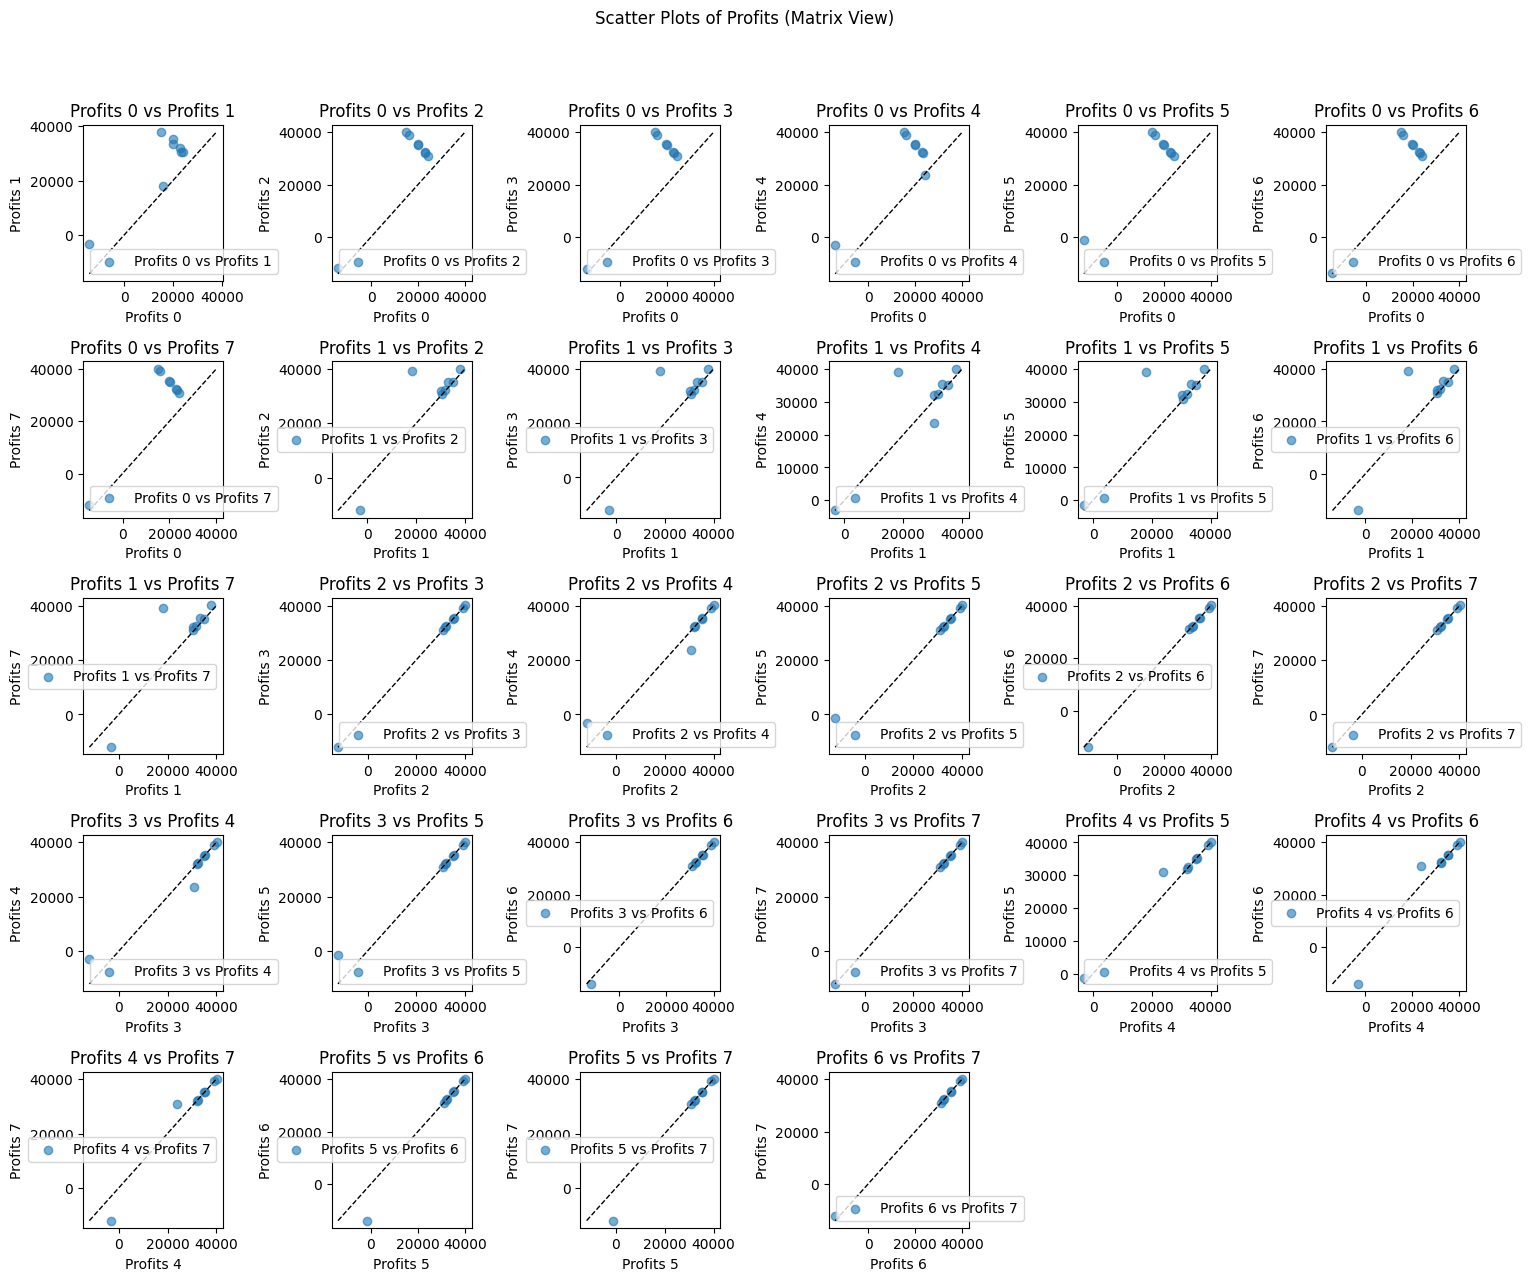

In [120]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
]
plot_strategies_profits_scatter(dfs)

#### 最大利潤比較


Baseline is: 15886.854565824811
S1's profit: 26746.24686722893
S2's profit: 29134.98718974949
S3's profit: 40149.65204304685
S4's profit: 40149.65204304688
S5's profit: 40149.65204304685
S6's profit: 40149.652043046844
S7's profit: 40149.65204304685


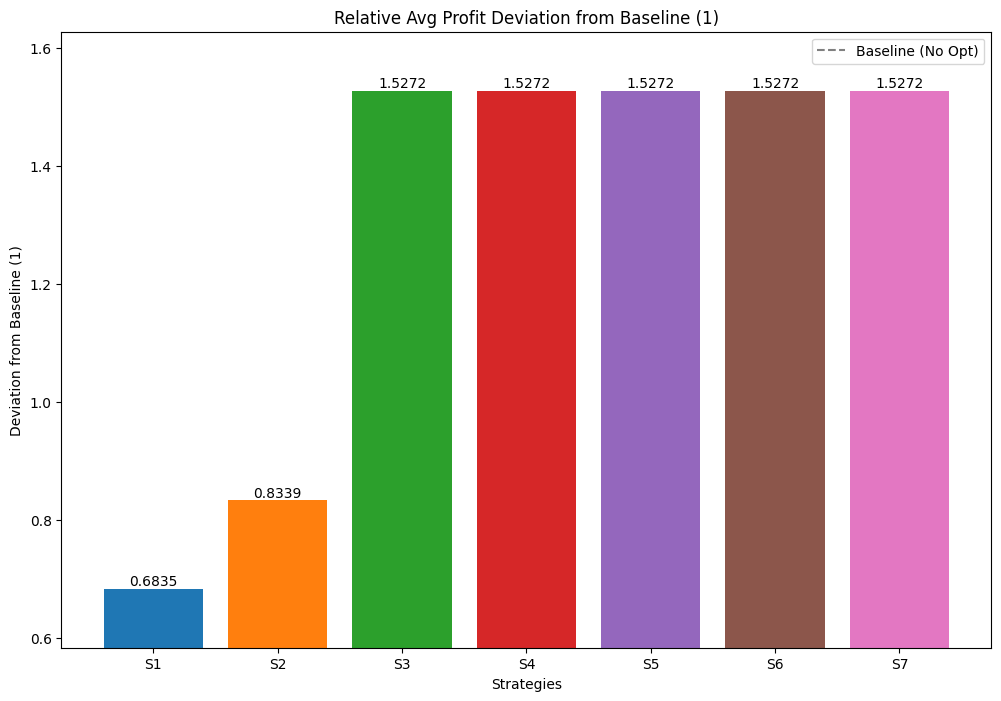

In [121]:
# 使用範例
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
]

plot_relative_profit_deviation(float(baseline_avg_profits), train_max_profits)

### Preparation


In [122]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7

## Testing


### Setting reasonable parameters


In [123]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 165.23025333702137
std of sum: 32.36898528744641
20.0 percentile of sum: 137.9878280098972
Q_star: 137.9878280098972


In [124]:
demand_df_test = demand_df_test.reset_index(drop=True)
demand_df_test

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,31.505618,21.210760,24.618329,17.095606,0.00000,14.73066,13.984576,26.554973,10.953144,22.427897
1,24.345054,13.106678,21.160794,12.446863,15.91661,13.10696,16.836396,14.527569,0.000000,9.362829


In [125]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)
Qk_hat_df_test

mu_matrix: [27.92533577 17.15871861 22.88956125 14.77123451  7.9583052  13.91881011
 15.41048579 20.5412708   5.47657213 15.89536266]
covariance_matrix: 
[[  25.63684021   29.01490008   12.37895081   16.64381466  -56.98595574
     5.81330461  -10.21032052   43.06149864   39.21534661   46.77662889]
 [  29.01490008   32.83807286   14.01007371   18.83690093  -64.49475824
     6.57929959  -11.55569201   48.73553332   44.38258983   52.94019084]
 [  12.37895081   14.01007371    5.97727419    8.03659738  -27.51611888
     2.80700005   -4.93013392   20.79258478   18.93543989   22.58646477]
 [  16.64381466   18.83690093    8.03659738   10.80540987  -36.99612267
     3.77408306   -6.62869062   27.95615982   25.45918121   30.36807715]
 [ -56.98595574  -64.49475824  -27.51611888  -36.99612267  126.66924333
   -12.92190131   22.6956547   -95.71774974  -87.1684649  -103.97579738]
 [   5.81330461    6.57929959    2.80700005    3.77408306  -12.92190131
     1.31820108   -2.31525035    9.7644486     8.

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2930819029.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2930819029.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2930819029.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2930819029.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2930819029.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2930819029.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,183.081561,183.081562,183.081562,183.081561,183.081562,183.081561,183.081562,183.081561
1,140.809751,140.809751,140.809751,140.809751,140.809751,140.809751,140.809751,140.809751


### Run all the strategies


Baseline

In [126]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/2 with initial inventory Q_star=137.9878280098972
--------------------------------------------------
Day 1
Demand      : 31.505617900254535
Sales       : 31.505617900254535
Loss        : 0
Left        : 106.48221010964268
Inventory   : 106.48221010964268
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 21.210759626991518
Sales       : 21.210759626991518
Loss        : 0
Left        : 85.27145048265116
Inventory   : 85.27145048265116
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 24.61832875495145
Sales       : 24.61832875495145
Loss        : 0
Left        : 60.65312172769971
Inventory   : 60.65312172769971
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 17.095606455944047
Sales       : 17.095606455944047
Loss        : 0
Left        : 43.55751527175566


In [127]:
test_stimulation_df_baseline

,losses,lefts,operation_profits,profits
0,45.093734,0.0,27597.565602,18578.818770
1,2.821923,0.0,27597.565602,27033.180907


S1

In [128]:
results_df_1

,R(T),F,Q0,average_profits,average_losses,average_lefts,average_operation_profits,baseline_profit,profit_diff_percent
53,7,0.9,124.189045,26746.246867,4.112640,5.818435,32223.522758,15886.854566,68.354577
24,4,0.7,96.591480,26543.903047,15.986349,0.134510,29848.780904,15886.854566,67.080922
23,4,0.6,82.792697,26190.287276,16.281029,0.429190,29789.844942,15886.854566,64.855083
44,6,0.9,124.189045,26083.279287,6.345231,5.530849,31777.004567,15886.854566,64.181520
52,7,0.8,110.390262,25800.374993,6.050765,6.031712,31835.897732,15886.854566,62.400775
...,...,...,...,...,...,...,...,...,...
55,8,0.2,27.597566,-73864.171049,89.091852,89.091851,15227.680317,15886.854566,-564.938926
65,9,0.3,41.396348,-78125.009920,92.642551,92.642550,14517.540502,15886.854566,-591.758829
54,8,0.1,13.798783,-90422.710410,102.890635,102.890634,12467.923757,15886.854566,-669.166854
64,9,0.2,27.597566,-94683.549281,106.441334,106.441333,11757.783942,15886.854566,-695.986757


In [129]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.9, R: 7
Q_star 為 137.9878280098972
期初庫存 Q0: 124.1890452089075
重新估計量 Qk_hat: 183.08156132908363
訂貨量 Q1 為 58.892516120176126

第一階段：期初庫存 Q0: 124.1890452089075，需求量為 109.16097291903525，Sold_0 為 109.16097291903525，Left_0 為 15.028072289872256，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 73.92058841004838，需求量為 73.9205892516696，Sold_1 為 73.92058841004838，Left_1 為 0.0，Lost_1 為 8.416212153861125e-07

統計結果：Sold 為 183.08156132908363, Lost 為 8.416212153861125e-07 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 0.0001683242430772225，Profit 為 36616.31209749248
----------------------------------------
這是第 2 筆模擬資料

F: 0.9, R: 7
Q_star 為 137.9878280098972
期初庫存 Q0: 124.1890452089075
重新估計量 Qk_hat: 140.80975064153648
訂貨量 Q1 為 16.62070543262898

第一階段：期初庫存 Q0: 124.1890452089075，需求量為 100.0829579792498，Sold_0 為 100.0829579792498，Left_0 為 24.106087229657703，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 40.726792662286684，需求量為 40.726793503907935，Sold_1 為 40.726792662286684，Left_1 為 0.0，Lost_1 為 8.416212509132492e-07

統計

,R(T),F,Q0,average_profits,average_losses,average_lefts,average_operation_profits
0,7,0.9,124.189045,32389.131029,8.416212e-07,0.0,32389.131197


S2

In [130]:
results_df_2

,R(T),R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,F_vars,Q0_vars,Q1_vars
0,2,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,115.087792,33046.050667,29134.987190,"[0.0, 0.0, 2.065739925773621]","[0.726356732438781, 0.7790332196150247, 0.8875...","[100.22838786959343, 107.49710192223452, 122.4...","[40.456479949727765, 40.45649652326691, 40.456..."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1]",0.0,124.334425,33046.050667,28892.457357,"[0.0, 0.0, 6.475663576628612]","[0.9981436774907717, 0.9980367129326929, 0.998...","[137.73167809876293, 137.7169182917196, 137.77...","[0.0, 7.980107249094431, 40.456385201472614, 1..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2]",0.0,98.896340,33046.050667,28842.038674,"[0.07209790045473738, 0.05167611808908563, 0.0]","[0.9976567298017597, 0.9984037440759171, 0.998...","[137.6644852448017, 137.7675641219851, 137.723...","[2.367599655811887, 29.59869331121564, 35.5909..."


In [131]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

assigned_R: 0


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/1149000371.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


,average_profits,average_loss,average_left,alpha_values,R(T)
0,32389.131029,0.000168,0.000168,"[0.0, 0.0, 2.065739925773621]",2


In [132]:
test_stimulation_results_df_2

,F,R(T),Sold_0,Left_0,Lost_0,Sold_1,Left_1,Lost_1,profits,Q0,Q1
0,0.887528,2,31.505618,90.962500,0.0,151.575943,0.0,8.416212e-07,36616.312097,122.468118,60.613443
1,0.887528,2,24.345054,98.123065,0.0,116.464697,0.0,8.416212e-07,28161.949960,122.468118,18.341632


S3

In [133]:
results_df_3

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,29119.436624,0.0,87.011451,33046.050667,"[2.438146502480724e-06, 2.112109215950598e-06,...","[[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0..."


In [134]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None:
    alphas = results_df_3.iloc[0]["alpha_values"]
    betas = results_df_3.iloc[0]["beta_values"]

    test_results_df_3, test_stimulation_results_df_3 = (
        cal_test_fully_flexible_simple_beta_with_softmax_3(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_3

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/635627248.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


,average_profits,average_loss,average_left,alpha_values,beta_balues
0,23872.394364,0.000168,0.000168,"[2.438146502480724e-06, 2.112109215950598e-06,...","[[-4.0], [-4.0], [-4.0], [-4.0], [-4.0], [-4.0..."


In [135]:
test_stimulation_results_df_3

,F,R(T),Sold_0,Left_0,Lost_0,Sold_1,Left_1,Lost_1,profits,Q0,Q1
0,0.982014,9,135.505959,0.000000,14.194562,33.381041,14.194561,0.000000e+00,19582.838769,135.505959,47.575602
1,0.982014,2,24.345054,111.160866,0.000000,116.464697,0.000000,8.416212e-07,28161.949960,135.505920,5.303831


S4

In [136]:
results_df_4

,R(T),average_losses,average_lefts,average_operation_profits,average_profits,beta_values,F_vars,Q0_vars,Q1_vars
0,"[9, 6, 2, 5, 9, 9, 9, 4]",0.755648,55.712391,32894.921086,29344.334196,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]","[124.1890452089075, 124.1890452089075, 124.189...","[30.57407477027796, 38.20317305187935, 38.7355..."


In [137]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    assigned_F = results_df_4.iloc[0]["F_vars"]
    betas = results_df_4.iloc[0]["beta_values"]
    test_results_df_4, test_stimulation_results_df_4 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_4

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/2606609425.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


,average_profits,average_loss,average_left,beta_balues,F
0,32389.131029,0.000168,0.000168,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.9


In [138]:
test_stimulation_results_df_4

,F,R(T),Sold_0,Left_0,Lost_0,Sold_1,Left_1,Lost_1,profits,Q0,Q1
0,0.9,2,31.505618,92.683427,0.0,151.575943,0.0,8.416212e-07,36616.312097,124.189045,58.892516
1,0.9,2,24.345054,99.843992,0.0,116.464697,0.0,8.416212e-07,28161.949960,124.189045,16.620705


S5

In [139]:
results_df_5

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,30466.379697,0.0,81.889978,33046.050667,"[0.024338472395502377, 0.0, 0.0]","[[-0.08949069026857615], [-0.08949051923568178..."


In [140]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/18362809.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


,average_profits,average_loss,average_left,alpha_values,beta_balues
0,32389.131029,0.000168,0.000168,"[0.024338472395502377, 0.0, 0.0]","[[-0.08949069026857615], [-0.08949051923568178..."


S6

In [141]:
results_df_6

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,28899.896065,0.0,57.989523,33046.050667,"[0.0, 3.2943724563735373, 0.053659734298834076]","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [142]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/1094914333.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


,average_profits,average_loss,average_left,alpha_values,beta_balues
0,32389.131029,0.000168,0.000168,"[0.0, 3.2943724563735373, 0.053659734298834076]","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [143]:
test_stimulation_results_df_6

,F,R(T),Sold_0,Left_0,Lost_0,Sold_1,Left_1,Lost_1,profits,Q0,Q1
0,0.998698,2,31.505618,106.302524,0.0,151.575943,0.0,8.416212e-07,36616.312097,137.808142,45.273420
1,0.966040,2,24.345054,108.956754,0.0,116.464697,0.0,8.416212e-07,28161.949960,133.301808,7.507943


S7

In [144]:
results_df_7

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values
0,29134.98719,0.0,133.599395,33046.050667,"[0.024338472395502377, 0.0, 0.0]","[[0.0, 0.0894717835347194, -0.2684342573380149..."


In [145]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

alphas: [0.02433847 0.         0.        ]
betas: [[ 0.00000000e+00  8.94717835e-02 -2.68434257e-01]
 [ 0.00000000e+00  0.00000000e+00 -8.94906903e-02]
 [ 0.00000000e+00  8.94717835e-02 -2.68434257e-01]
 [-4.30162804e-01 -5.18632534e-01  3.72560896e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.02111726e-02  3.33840397e-02 -1.86159408e+00]
 [-2.76764569e-01  1.13466355e-01  2.30643461e+01]]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_72334/3388500623.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


,average_profits,average_loss,average_left,alpha_values,beta_balues
0,32389.131029,0.000168,0.000168,"[0.024338472395502377, 0.0, 0.0]","[[0.0, 0.0894717835347194, -0.2684342573380149..."


In [146]:
test_stimulation_results_df_7

,F,R(T),Sold_0,Left_0,Lost_0,Sold_1,Left_1,Lost_1,profits,Q0,Q1
0,0.898587,5,94.430313,29.563710,0.0,88.651249,0.0,8.416212e-07,36616.312097,123.994022,59.087539
1,0.884974,2,24.345054,97.770608,0.0,116.464697,0.0,8.416212e-07,28161.949960,122.115662,18.694089


### Analysis

#### 組內比較

##### Profits Scatter

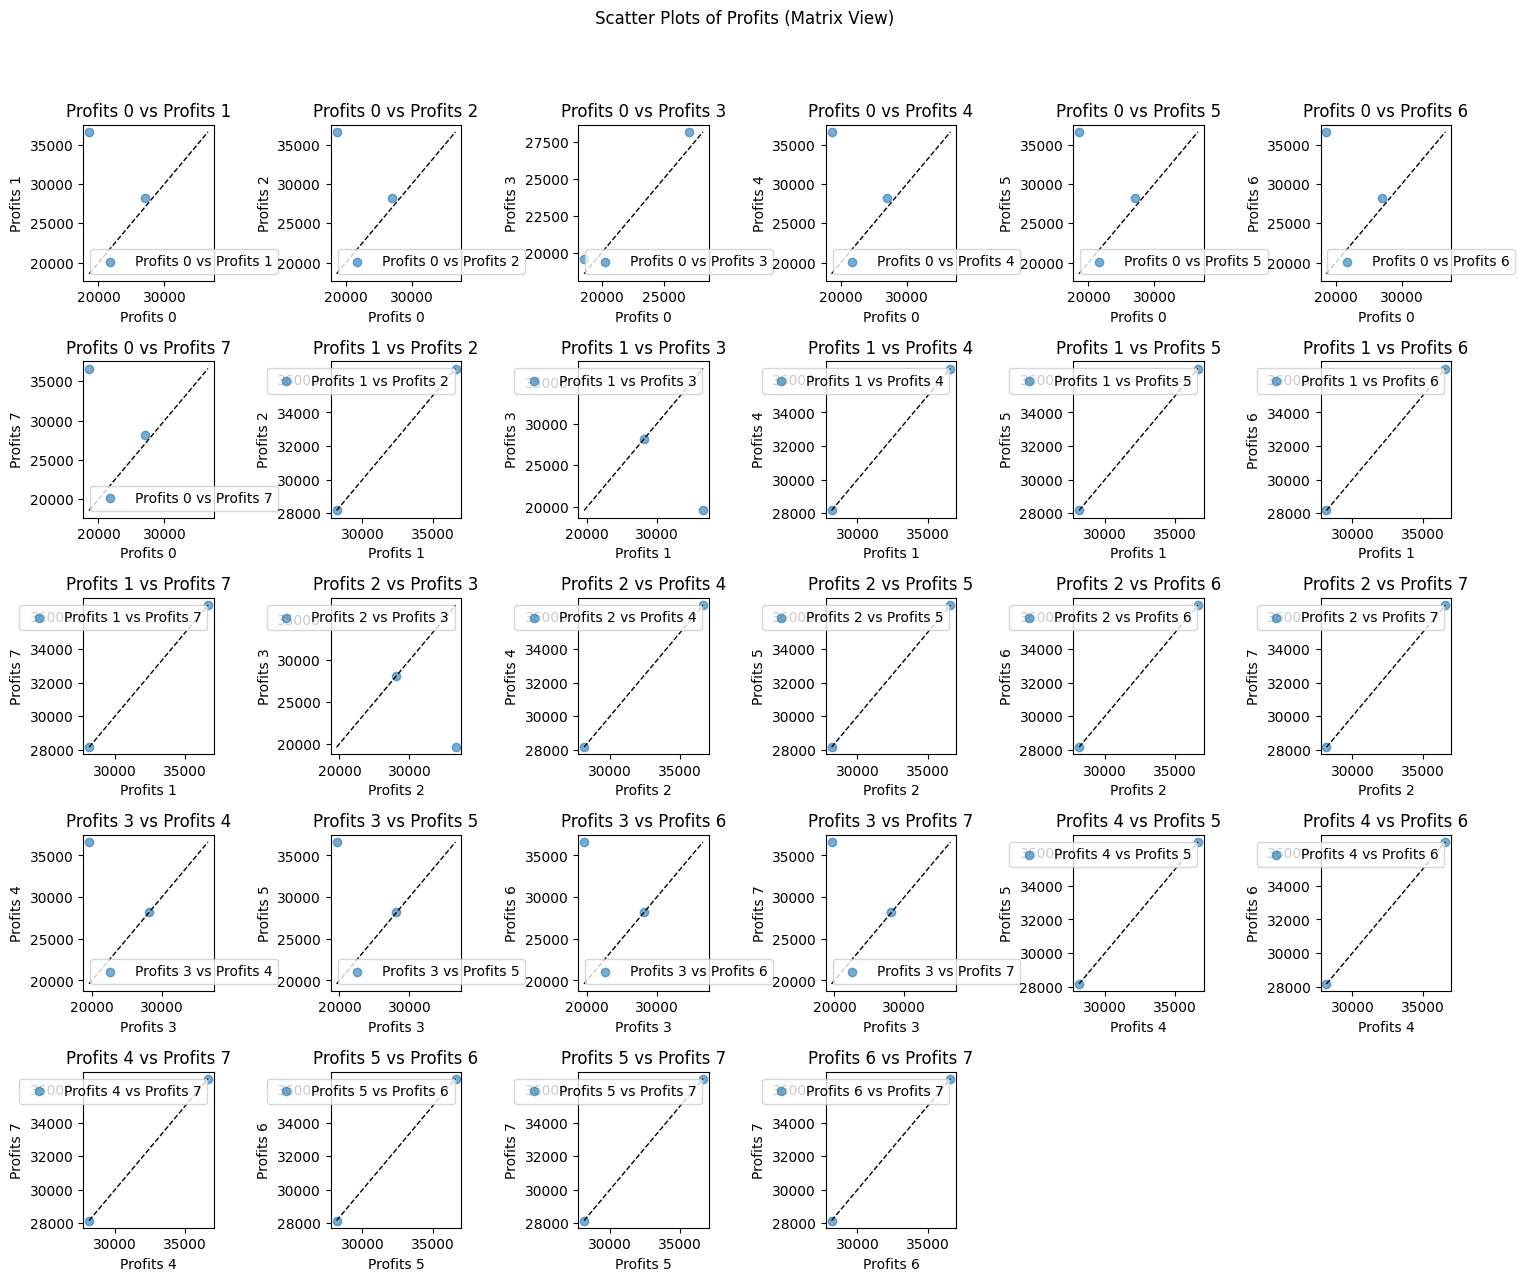

In [147]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
]

plot_strategies_profits_scatter(dfs)

##### Profit Deviation

Baseline is: 22805.99983857263
S1's profit: 32389.131028737764
S2's profit: 32389.131028737767
S3's profit: 23872.39436445437
S4's profit: 32389.131028737767
S5's profit: 32389.131028737767
S6's profit: 32389.131028737764
S7's profit: 32389.13102873776


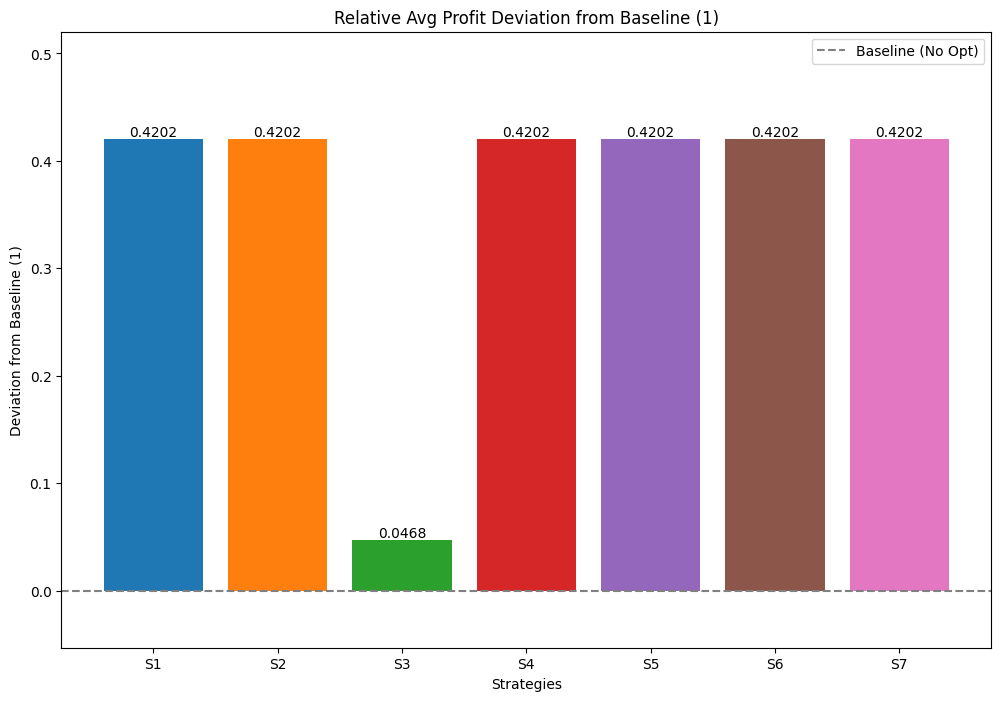

In [148]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
]
plot_relative_profit_deviation(test_baseline_avg_profits, test_max_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

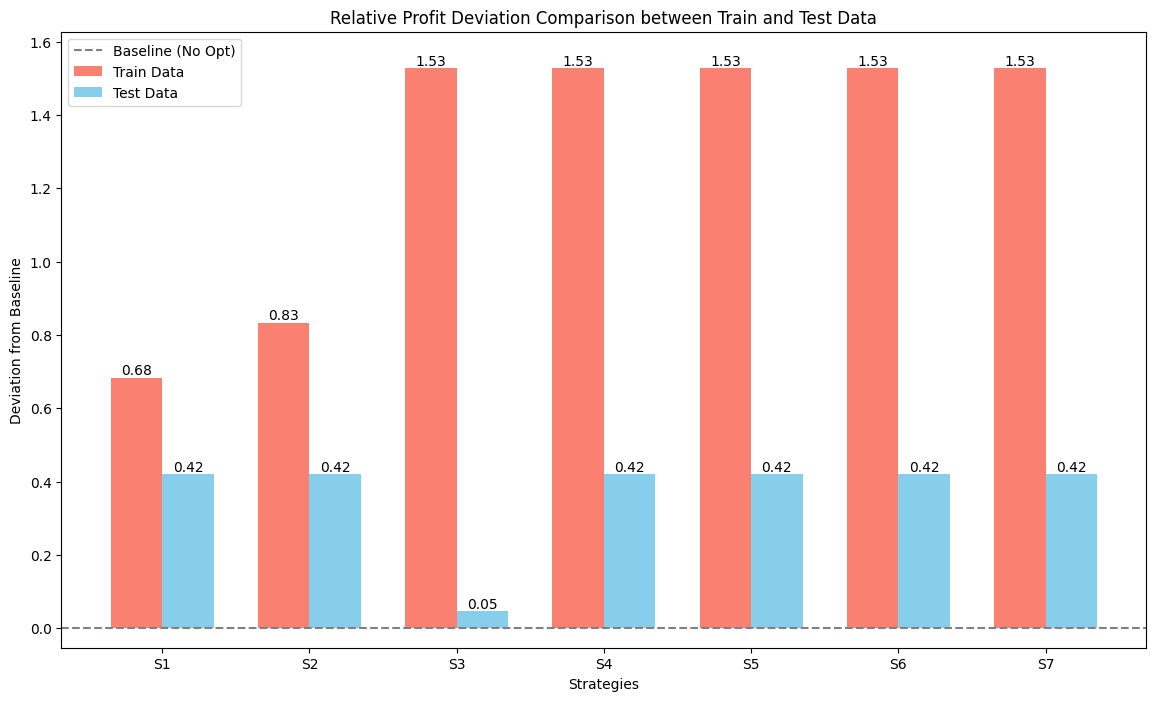

In [149]:
# Plot the comparison
plot_relative_profit_comparison(
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [150]:
# 將變數名稱存取為此 Margin 特別的變數

# 總和分析


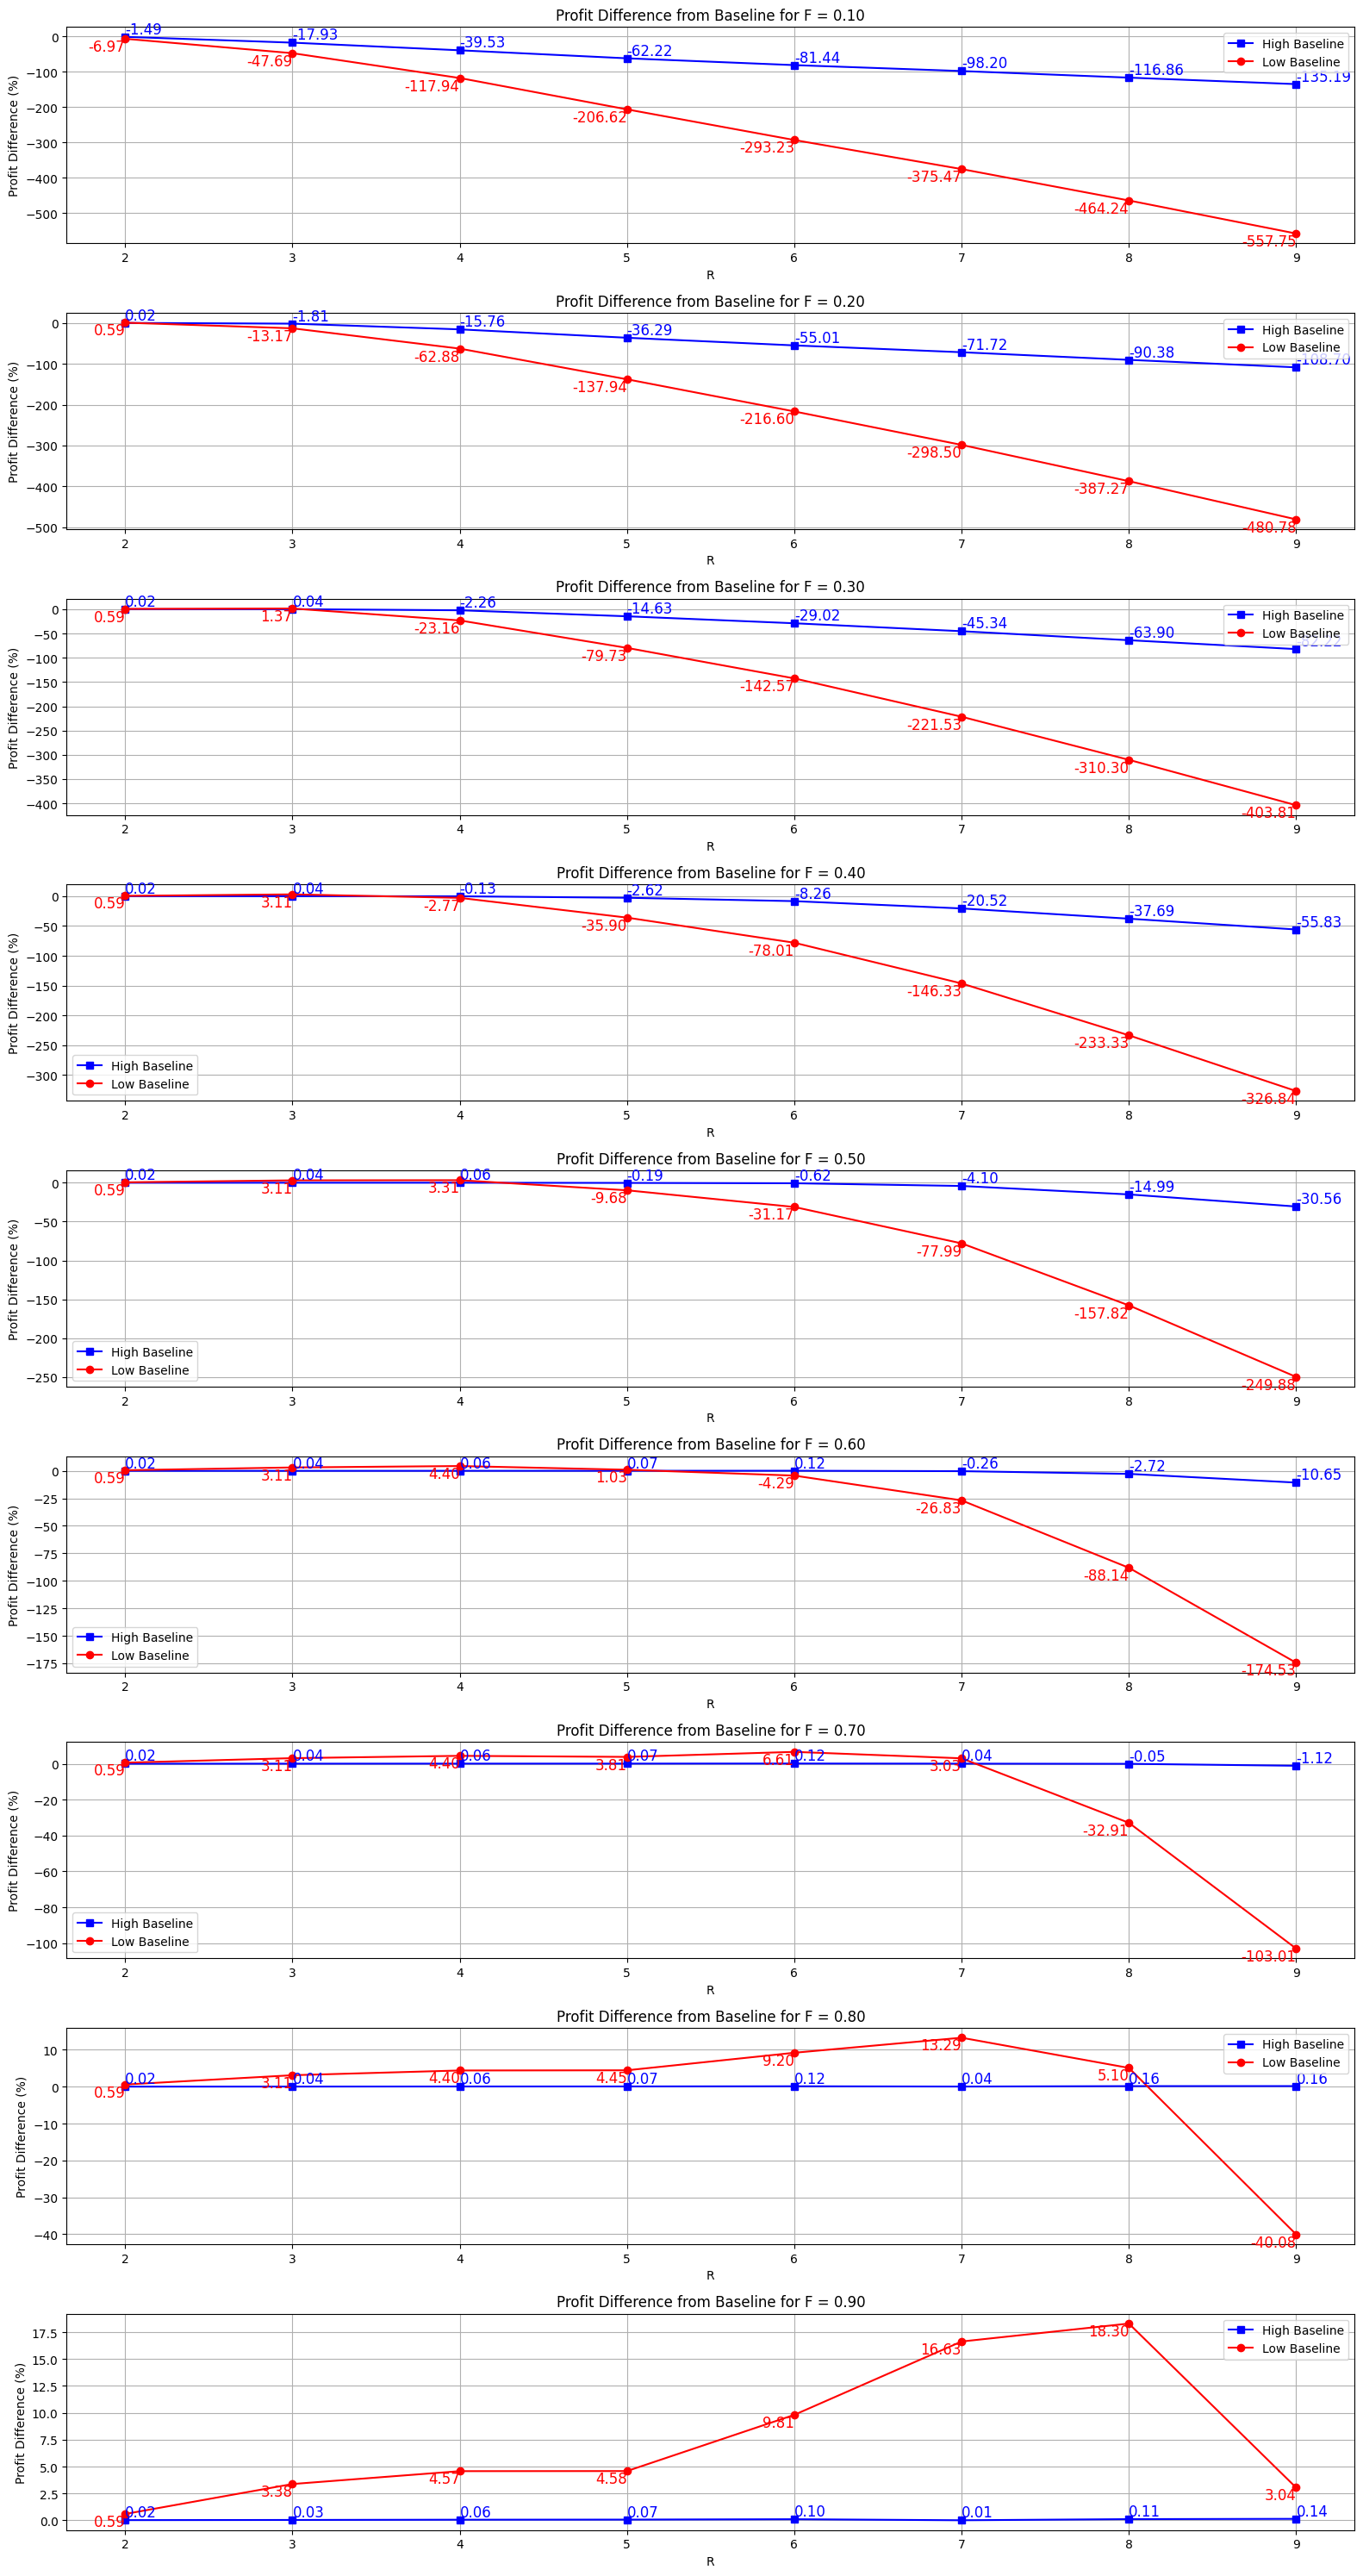

In [ ]:
# # Plotting
# plt.figure(figsize=(16, 30))

# # Traverse through different F values to plot merged subplots
# for idx, F in enumerate(assigned_Fs):
#     plt.subplot(len(assigned_Fs), 1, idx + 1)

#     # Select high baseline data corresponding to F
#     subset_high = (
#         high_results_df_1[high_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_high["R"],
#         subset_high["profit_diff_percent"],
#         marker="s",
#         linestyle="-",
#         color="blue",
#         label="High Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_high["R"], subset_high["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="blue", ha="left", va="bottom")

#     # Select low baseline data corresponding to F
#     subset_low = (
#         low_results_df_1[low_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_low["R"],
#         subset_low["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         color="red",
#         label="Low Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_low["R"], subset_low["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="red", ha="right", va="top")

#     plt.xlabel("R")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()
# plt.show()

# Drafts


In [ ]:
# def check_values(Q1, Q_hat_adjusted, Q0,
#                  Sold_0, total_demand_up_to_k_minus_1,
#                  Q0_var, Sold_1, total_demand_from_k_to_T,
#                  Q1_plus_left, Left_0, Lost_0, Left_1, Lost_1):

#     i=0
#     print("---------------------------------------")
#     print(f"Start to check the values: ")

#     # 檢查條件 1：Q1_vars[i].X 一定是等於 Q_hats[i].X - Q0_vars[i].X（值為 Q_hat_adjusted） 或是 0
#     if not (Q1 == Q_hat_adjusted or Q1 == 0):
#         print(f"Error: Q1 ({Q1}) should be equal to Q_hat_adjusted ({Q_hat_adjusted}) or 0")
#         i+=1

#     # 檢查條件 2：Sold_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X 或是 Q0_vars[i].X
#     if not (Sold_0 == total_demand_up_to_k_minus_1 or Sold_0 == Q0):
#         print(f"Error: Sold_0 ({Sold_0}) should be equal to total_demand_up_to_k_minus_1 ({total_demand_up_to_k_minus_1}) or Q0 ({Q0})")
#         i+=1

#     # 檢查條件 3：Sold_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X 或是 Q1_plus_lefts[i].X
#     if not (Sold_1 == total_demand_from_k_to_T or Sold_1 == Q1_plus_left):
#         print(f"Error: Sold_1 ({Sold_1}) should be equal to total_demand_from_k_to_T ({total_demand_from_k_to_T}) or Q1_plus_left ({Q1_plus_left})")
#         i+=1

#     # 檢查條件 4：Left_0s[i].X 一定等於 Q0_vars[i].X - Sold_0s[i].X 或是 0
#     if not (Left_0 == Q0 - Sold_0 or Left_0 == 0):
#         print(f"Error: Left_0 ({Left_0}) should be equal to Q0 - Sold_0 ({Q0 - Sold_0}) or 0")
#         i+=1

#     # 檢查條件 5：Left_1s[i].X 一定等於 Q1_plus_lefts[i].X - Sold_1s[i].X 或是 0
#     if not (Left_1 == Q1_plus_left - Sold_1 or Left_1 == 0):
#         print(f"Error: Left_1 ({Left_1}) should be equal to Q1_plus_left - Sold_1 ({Q1_plus_left - Sold_1}) or 0")
#         i+=1

#     # 檢查條件 6：Lost_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X - Q0_vars[i].X 或是 0
#     if not (Lost_0 == total_demand_up_to_k_minus_1 - Q0 or Lost_0 == 0):
#         print(f"Error: Lost_0 ({Lost_0}) should be equal to total_demand_up_to_k_minus_1 - Q0 ({total_demand_up_to_k_minus_1 - Q0}) or 0")
#         i+=1

#     # 檢查條件 7：Lost_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X - Q1_plus_lefts[i].X 或是 0
#     if not (Lost_1 == total_demand_from_k_to_T - Q1_plus_left or Lost_1 == 0):
#         print(f"Error: Lost_1 ({Lost_1}) should be equal to total_demand_from_k_to_T - Q1_plus_left ({total_demand_from_k_to_T - Q1_plus_left}) or 0")
#         i+=1

#     if i == 0:
#         print(f"All Pass!")
#     else:
#         print(f"There are {i} wrongs!")

#     print("---------------------------------------")

In [ ]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addConstr(Left_0s[i] >= aux_left_0, name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")
# model.addConstr(Left_0s[i] <= aux_left_0, name=f"Constr_Left_0_3_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addConstr(Lost_0s[i] >= aux_lost_0, name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")
# model.addConstr(Lost_0s[i] <= aux_lost_0, name=f"Constr_Lost_0_3_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - Sold_1s[i], name=f"constr_aux_left_1_{i}")
# model.addConstr(Left_1s[i] >= aux_left_1, name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")
# model.addConstr(Left_1s[i] <= aux_left_1, name=f"Constr_Left_1_3_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addConstr(Lost_1s[i] >= aux_lost_1, name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")
# model.addConstr(Lost_1s[i] <= aux_lost_1, name=f"Constr_Lost_1_3_{i}")


# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [ ]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# model.addConstr(Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

# # 計算 Lost_0
# model.addConstr(Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# model.addConstr(Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

# # 計算 Lost_1
# model.addConstr(Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [ ]:
# # 計算 Sold_0
# model.addGenConstrMin(Sold_0s[i], [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]], name=f"Sold_0_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addGenConstrMax(Left_0s[i], [aux_left_0], 0.0, f"Left_0_Max_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addGenConstrMax(Lost_0s[i], [aux_lost_0], 0.0, f"Lost_0_Max_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addGenConstrMin(Sold_1s[i], [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],  name=f"Sold_1_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - total_demand_from_k_to_T_vars[i], name=f"constr_aux_left_1_{i}")
# model.addGenConstrMax(Left_1s[i], [aux_left_1], 0.0, f"Left_1_Max_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addGenConstrMax(Lost_1s[i], [aux_lost_1], 0.0, f"Lost_1_Max_{i}")